In [1]:
import measures, umls_tables_processing, utils
import datetime
from collections import defaultdict

from gensim.models import KeyedVectors, Word2Vec
from gensim.test.utils import datapath
# import data_visualization

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import numpy as np
import os
import pandas as pd


0:08:22


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-phk5brhp because the default path (/home/salvatore/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Processing MRREL table: elaboration of relationships and evaluation of which is more proper

In [37]:
_ = umls_tables_processing.count_relationships(rel_type = 'RELA')

844
0:01:06


This is the number of all the relationships `RELA` in the whole UMLS: they correspond to the particular relationships

In [3]:
umls_tables_processing.count_relationships(rel_type = 'REL')

10
0:02:41


{'AQ', 'CHD', 'PAR', 'QB', 'RB', 'RN', 'RO', 'RQ', 'SIB', 'SY'}

These are the `REL` relationships and the total number: they correspond to generical relationships

The following lines tell us which are the relationship which link the 256 elements of the seed with the concept `COPD`: this is an evolution of the original seed building method.

In [4]:
double_rel = umls_tables_processing.concepts_related_to_concept(two_way = True, polishing_rels = True, switch_key= 'con')

Relation '' discarded 


In [5]:
single_rel = umls_tables_processing.concepts_related_to_concept(two_way = False, polishing_rels = True, switch_key= 'con')

Relation '' discarded 


The two lines distinguish the both ways relationships from the one way.

#### Double ways

In [6]:
_ = set([i for j in double_rel.values() for i in j])
print(_)
print(len(_))

{'disease_has_associated_gene', 'may_be_treated_by', 'disease_has_associated_anatomic_site', 'focus_of', 'is_associated_anatomic_site_of', 'fragments_for_synonyms_of', 'contraindicated_with_disease', 'has_fragments_for_synonyms', 'was_a', 'classified_as', 'same_as', 'has_finding_site', 'possibly_equivalent_to', 'inverse_was_a', 'inverse_isa', 'finding_site_of', 'has_associated_morphology', 'entry_version_of', 'see_from', 'has_course', 'has_cdrh_parent', 'has_focus', 'replaces', 'has_expanded_form', 'expanded_form_of', 'cdrh_parent_of', 'has_entry_version', 'associated_with_malfunction_of_gene_product', 'associated_morphology_of', 'subset_includes_concept', 'clinical_course_of', 'use', 'related_to', 'isa', 'used_for', 'gene_associated_with_disease', 'has_answer', 'has_contraindicated_drug', 'answer_to', 'has_associated_finding', 'replaced_by', 'has_clinical_course', 'mapped_from', 'concept_in_subset', 'may_treat', 'classifies', 'gene_product_malfunction_associated_with_disease', 'see', 

#### One way

In [7]:
_ = set([i for j in single_rel.values() for i in j])
print(_)
print(len(_))

{'is_associated_anatomic_site_of', 'contraindicated_with_disease', 'has_fragments_for_synonyms', 'was_a', 'classified_as', 'same_as', 'possibly_equivalent_to', 'inverse_was_a', 'inverse_isa', 'finding_site_of', 'has_focus', 'entry_version_of', 'see_from', 'has_cdrh_parent', 'has_expanded_form', 'expanded_form_of', 'cdrh_parent_of', 'has_entry_version', 'associated_morphology_of', 'subset_includes_concept', 'clinical_course_of', 'use', 'related_to', 'isa', 'used_for', 'gene_associated_with_disease', 'has_answer', 'has_associated_finding', 'replaced_by', 'mapped_from', 'may_treat', 'gene_product_malfunction_associated_with_disease', 'see', 'mapped_to', 'has_manifestation', 'course_of'}
36


#### Building the seed for analogic evaluation: we obtain lists of CUIs for each relationship in which they're involved with COPD

In [4]:
seed_analog_both = umls_tables_processing.concepts_related_to_concept(two_way = True, switch_key = 'rel', extract_labels = True)
print(len(seed_analog_both))
#seed_analog_both

0:02:15
256
Time for extracting labels: 0:00:00
Extracting time: 0:02:15
Building seed time: 0:03:37
54


In [4]:
seed_analog_one = umls_tables_processing.concepts_related_to_concept(two_way = False, switch_key = 'rel')
print(len(seed_analog_one))
#seed_analog_one

0:00:52
37


In place of building the list of copd-related CUIs, the seed_analog_one is re-elaborated for returning a list of concepts.

The seed_analog_one is used just for the reason it has not extracted labels, so it is more comfortable handling it.

In [6]:
tmp = [v for k,v in seed_analog_one.items()]
concepts = list(set([i for j in tmp for i in j]))

In counting the number of RELA relationships, the second approach return one more relation: it is due to the presence of the emtpy relation `''`

The `''` relation is problematic because contains plenty of key-concepts for our case and it is more similar to the concept of `relatedness`

The two sets of L and K are built: the boundary for the first is just the presence of relationships COPD-related.

In [7]:
all_copd_relations = list(seed_analog_both.keys())

### A subset of the 53 relationships extracted from seed, is detected

#### Used relationships (RELA)

They are choosen by hand

In [2]:
useful_rela = umls_tables_processing.USEFUL_RELA
useful_rela.append('')
useful_rela

['associated_finding_of',
 'associated_morphology_of',
 'associated_with_malfunction_of_gene_product',
 'clinical_course_of',
 'contraindicated_with_disease',
 'course_of',
 'disease_has_associated_anatomic_site',
 'disease_has_associated_gene',
 'finding_site_of',
 'gene_associated_with_disease',
 'gene_product_malfunction_associated_with_disease',
 'has_associated_finding',
 'has_associated_morphology',
 'has_clinical_course',
 'has_contraindicated_drug',
 'has_course',
 'has_finding_site',
 'has_manifestation',
 'is_associated_anatomic_site_of',
 'manifestation_of',
 'may_be_treated_by',
 'may_treat',
 '']

Building of K sets: two sets are built, one with both elements related to COPD and the other one to all the pairs which at least an element belonging to seed (the 256 elements extracted to one hop far by COPD concept)  

In [ ]:
concepts = umls_tables_processing.concepts_related_to_concept(concept = umls_tables_processing.COPD,
                                                              two_way = True,
                                                              polishing_rels = False,
                                                              switch_key = 'con',
                                                              extract_labels = False)

K_umls_copd = umls_tables_processing.count_pairs(umls_tables_processing.USEFUL_RELA, 
                                                 cuis_list = [umls_tables_processing.COPD])


In [3]:
K_umls_copd = utils.inputs_load('Utilities/K_umls_copd')

0:00:00


In [ ]:
K_umls = umls_tables_processing.count_pairs(useful_rela, cuis_list = concepts)

In [272]:
K_umls = utils.inputs_load('Utilities/K_umls')

0:00:03


In [ ]:
L_umls = umls_tables_processing.count_pairs(umls_tables_processing.USEFUL_RELA)

In [273]:
L_umls = utils.inputs_load('Utilities/L_umls')

0:00:34


### Building a dictionary with all the CUIs of L_umls and the correspondent labels.

- 1 step: a set of unique CUIs taken from the pairs of L_umls is built. 
-  2 step: for each, all the correspondent labels are extracted.
##### A dictionary built in this way could be used in `analogy_compute` and it is even useful for building the K set

####  A good way to operate could be filtering the `dict_labels_for_L` with the Vocabular of embedding: performing an intersection

This process is the step before running the analogy pipeline for w2v embeddings.

In [ ]:
# Building the dictionary for labels case
# Collecting all the CUIs involved in set L
jh = []
for v in L_umls.values():
    jh.append(list(set(list(zip(*v))[0])))
    jh.append(list(set(list(zip(*v))[1])))
    tmp = set([j for i in jh for j in i ])
dict_strings = umls_tables_processing.cui_strings()    
dict_labels_for_L, _ = umls_tables_processing.extracting_strings(list(tmp), dict_strings = dict_strings)

In [4]:
dict_labels_for_L = utils.inputs_load('Utilities/dict_labels_for_L')

0:00:17


### Loading all the embeddings paths for evaluating the cardinality of filtered IoV pairs.

Loading models and used variables

In [36]:
PATH_EMBEDDINGS = './Embeddings'
sets_relations = defaultdict(list)

cuis = ('/cuis/', [f.name for f in scandir(PATH_EMBEDDINGS+'/cuis') if (f.is_file())&(f.name != 'README.md')])
words = ('/words/', [f.name for f in scandir(PATH_EMBEDDINGS+'/words') if (f.is_file())&(f.name != 'README.md')])
embeddings = [cuis, words]
embeddings

[('/cuis/',
  ['claims_cuis_hs_300.txt.gz',
   'stanford_cuis_svd_300.txt.gz',
   'cui2vec_pretrained.txt',
   'DeVine_etal_200.txt']),
 ('/words/',
  ['PMC-w2v.bin',
   'Health_2.5mreviews.s200.w10.n5.v15.cbow.bin',
   'PubMed-and-PMC-w2v.bin',
   'GoogleNews-vectors-negative300.bin',
   'PubMed-w2v.bin',
   'tweetsvec.txt',
   'wikipedia-pubmed-and-PMC-w2v.bin'])]

### Cardinality of filtered sets per relation:

The code is taken from `analogy_pipeline` script

In [ ]:
a = datetime.datetime.now().replace(microsecond=0)

# Loop over the relations
for type_emb in embeddings:
    for emb in type_emb[1]:
        model = KeyedVectors.load_word2vec_format(PATH_EMBEDDINGS+type_emb[0]+emb, binary=emb.endswith('.bin'))
        name = os.path.splitext(emb)[0]
        print('Embedding ' + str(name) + ' is analyzed')
        for rela in useful_rela:
            # Check type of embedding
            if type_emb[0]=='/cuis/':
                c = datetime.datetime.now().replace(microsecond=0)
                l0, k0 = measures.k_n_l_iov(L_umls[rela], 
                                            K_umls[rela],
                                            model, 
                                            emb_type = 'cui')

                # sets_relations keeps track of the number of pairs of K and L sets. 
                # The number of filtered pairs on Vemb, per relation are stored
                sets_relations[rela].append(('L_'+name, np.shape(l0)))
                sets_relations[rela].append(('K_'+name, np.shape(k0)))
                #print(rela + ' for ' + name + ' finished!')
                    
            # Check type of embedding: for word embeddings the dictionary of labels per cui is required
            elif (type_emb[0]=='/words/') and (dict_labels_for_L is not None):
                c = datetime.datetime.now().replace(microsecond=0)
            
                # Filter the dictionary of labels keeping only the labels-words present into the embedding
                Vemb = utils.extract_w2v_vocab(model)
                dict_labels_inters_vemb = umls_tables_processing.discarding_labels_oov(Vemb, dict_labels_for_L)
            
                # Filtering L and K sets for present labels inside the embedding
                l0, k0 = measures.k_n_l_iov(L_umls[rela], 
                                            K_umls[rela],
                                            model, 
                                            dict_labels_for_L = dict_labels_inters_vemb,
                                            emb_type = 'labels')
        
                # Store number of filtered pairs
                sets_relations[rela].append(('L_'+name, np.shape(l0)))
                sets_relations[rela].append(('K_'+name, np.shape(k0)))

utils.inputs_save(sets_relations, 'Utilities/rela_dict_wor')                
print('Execution time : ' + str(datetime.datetime.now().replace(microsecond=0) - a) + '\n')

In [12]:
for rela in useful_rela:
    sets_relations[rela].append(('L', np.shape(L_umls[rela])))
    sets_relations[rela].append(('K', np.shape(K_umls[rela])))
utils.inputs_save(sets_relations, 'Utilities/rela_dict_wor')

In [5]:
sets_relations_r = utils.inputs_load('Utilities/rela_dict')

0:00:00


In [6]:
sets_relations = utils.inputs_load('Utilities/rela_dict_wor')

0:00:00


In [11]:
sets_relations_r

defaultdict(list,
            {'associated_finding_of': [('L_claims_cuis_hs_300.txt', (97, 2)),
              ('K_claims_cuis_hs_300.txt', (15, 2)),
              ('L_stanford_cuis_svd_300.txt', (0,)),
              ('K_stanford_cuis_svd_300.txt', (0,)),
              ('L_cui2vec_pretrained', (1388, 2)),
              ('K_cui2vec_pretrained', (118, 2)),
              ('L_DeVine_etal_200', (684, 2)),
              ('K_DeVine_etal_200', (43, 2)),
              ('L_PMC-w2v', (290, 2)),
              ('K_PMC-w2v', (18, 2)),
              ('L_Health_2.5mreviews.s200.w10.n5.v15.cbow', (167, 2)),
              ('K_Health_2.5mreviews.s200.w10.n5.v15.cbow', (5, 2)),
              ('L_PubMed-and-PMC-w2v', (298, 2)),
              ('K_PubMed-and-PMC-w2v', (18, 2)),
              ('L_GoogleNews-vectors-negative300', (244, 2)),
              ('K_GoogleNews-vectors-negative300', (17, 2)),
              ('L_PubMed-w2v', (296, 2)),
              ('K_PubMed-w2v', (18, 2)),
              ('L_tweetsvec',

In [9]:
sets_relations

defaultdict(list,
            {'associated_finding_of': [('L_claims_cuis_hs_300.txt', (57, 2)),
              ('K_claims_cuis_hs_300.txt', (10, 2)),
              ('L_stanford_cuis_svd_300.txt', (0,)),
              ('K_stanford_cuis_svd_300.txt', (0,)),
              ('L_cui2vec_pretrained', (827, 2)),
              ('K_cui2vec_pretrained', (58, 2)),
              ('L_DeVine_etal_200', (446, 2)),
              ('K_DeVine_etal_200', (23, 2)),
              ('L_PMC-w2v', (183, 2)),
              ('K_PMC-w2v', (9, 2)),
              ('L_Health_2.5mreviews.s200.w10.n5.v15.cbow', (109, 2)),
              ('K_Health_2.5mreviews.s200.w10.n5.v15.cbow', (4, 2)),
              ('L_PubMed-and-PMC-w2v', (188, 2)),
              ('K_PubMed-and-PMC-w2v', (9, 2)),
              ('L_GoogleNews-vectors-negative300', (151, 2)),
              ('K_GoogleNews-vectors-negative300', (8, 2)),
              ('L_PubMed-w2v', (187, 2)),
              ('K_PubMed-w2v', (9, 2)),
              ('L_tweetsvec', (77, 

In [25]:
len(set(L_umls['associated_finding_of']).difference(set(K_umls['associated_finding_of'])))

8675

In [26]:
len(set(L_umls['associated_finding_of']))

8923

In [27]:
len((set(K_umls['associated_finding_of'])))

248

In [ ]:
for rela in useful_rela:
    sets_relations[rela].append(('L wor', np.shape(list(set(L_umls[rela])))))
    sets_relations[rela].append(('K wor', np.shape(list(set(K_umls[rela])))))

In [ ]:
utils.inputs_save(sets_relations, 'Utilities/rela_dict_wor')

#### K and L cardinality data preparation

In [14]:
sets_rels_ordered = {}
for key, values in sets_relations.items():
    sets_rels_ordered[key] = ([val[1][0] for i, val in enumerate(values) if (i%2==0)], [val[1][0] for i, val in enumerate(values) if (i%2!=0)])    

# Plot with repetead couples

### Plot K_sets cardinality

Text(0, 0.5, 'Cardinality')

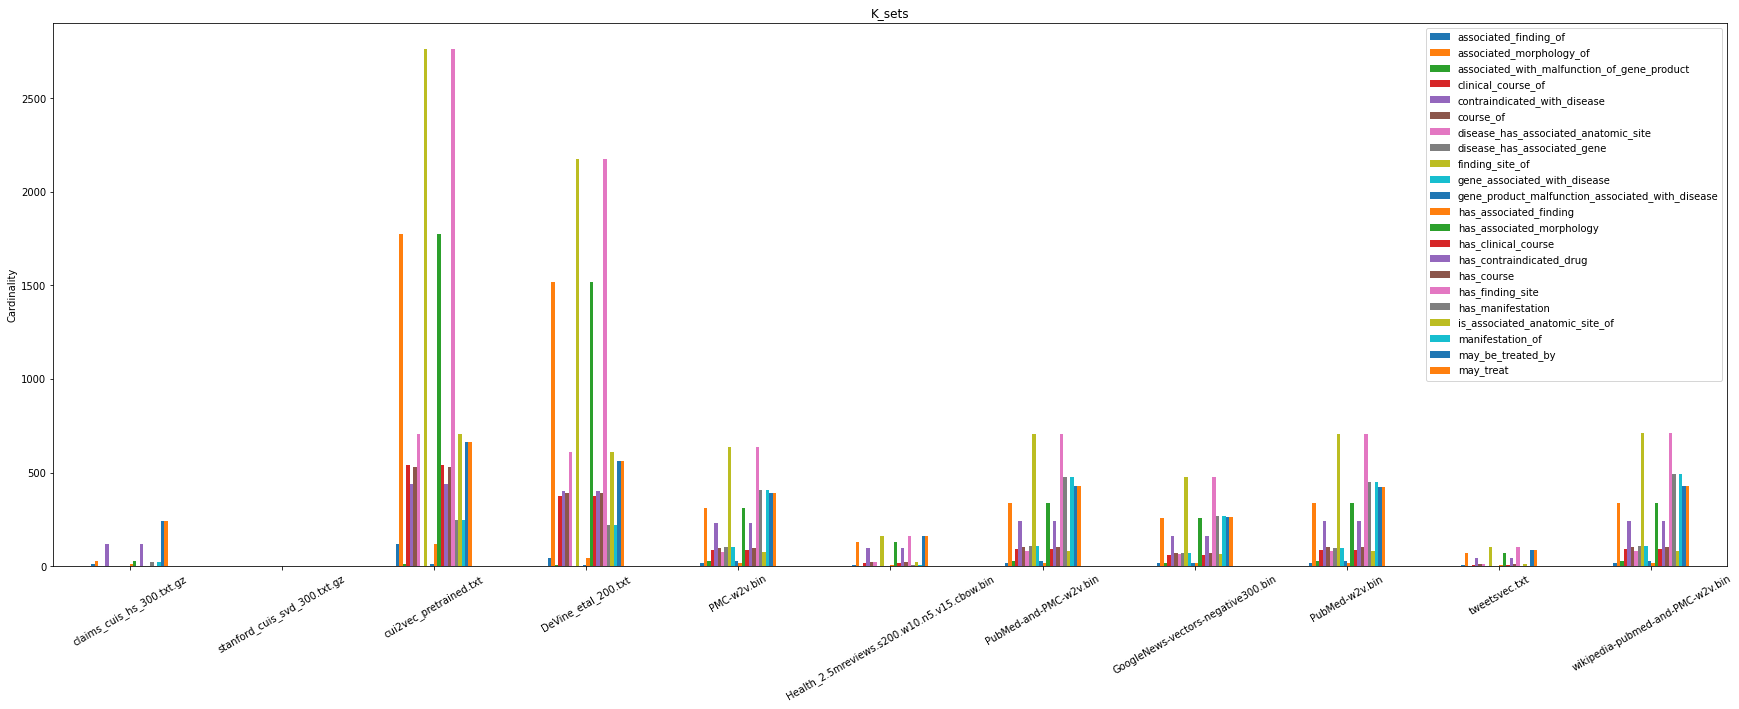

In [151]:
df_list = {}
names = embeddings[0][1]+embeddings[1][1]

for rela, i in sets_rels_ordered.items():
    #print(i[1])
    if rela == '':
        break
    df_list[rela] = i[1][:-1]

    
plotdata = pd.DataFrame(df_list, index = names)
plotdata.plot(kind="bar")

plt.title("K_sets")
plt.xticks(rotation = 30)
plt.ylabel("Cardinality")

### Plot L-sets cardinality

Text(0, 0.5, 'Cardinality')

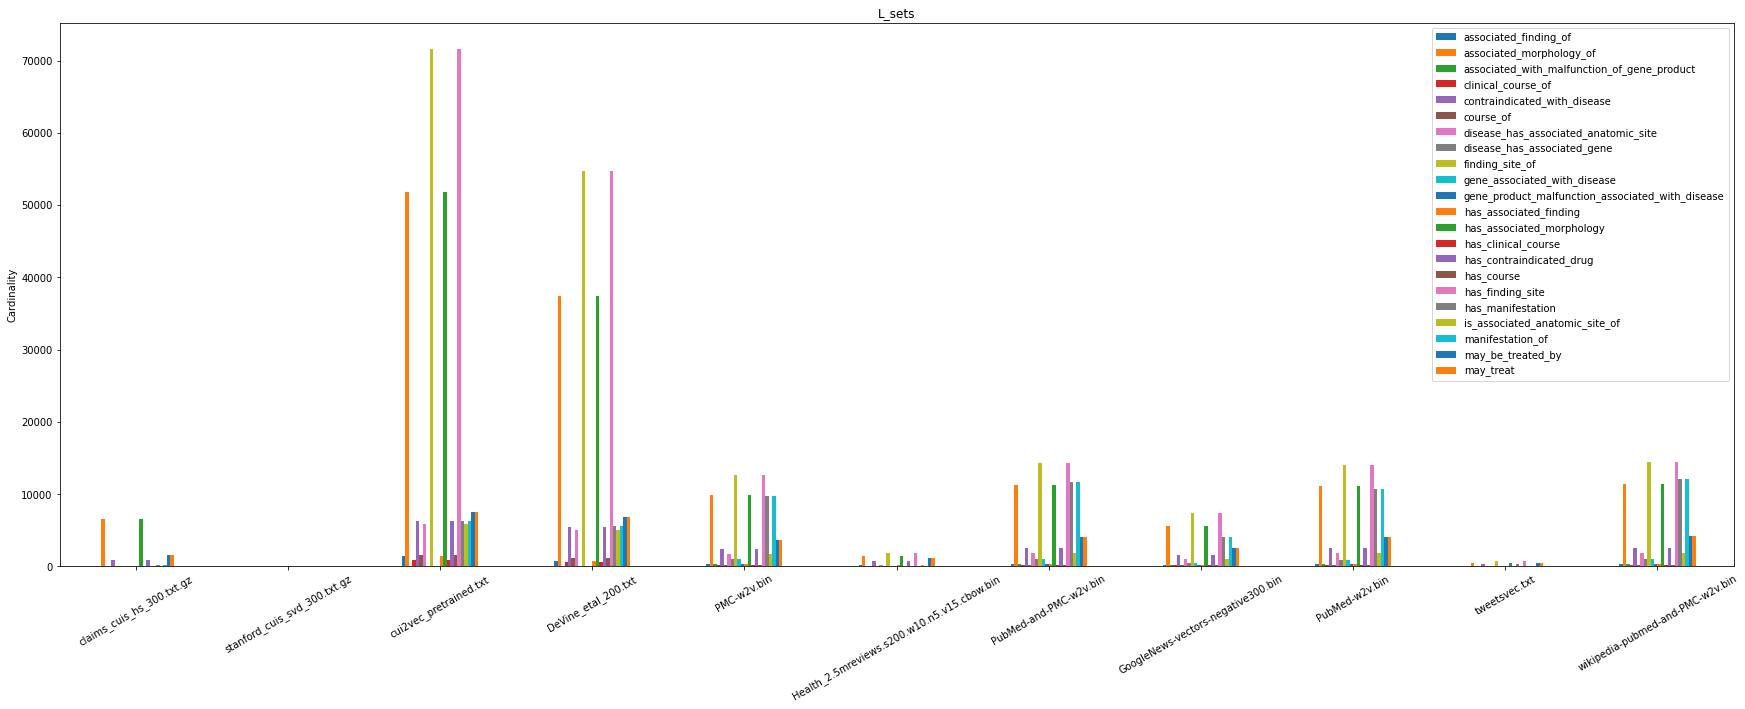

In [152]:
df_list = {}
names = embeddings[0][1]+embeddings[1][1]

for rela, i in sets_rels_ordered.items():
    #print(i[1])
    if rela == '':
        break
    df_list[rela] = i[0][:-1]

    
plotdata = pd.DataFrame(df_list, index = names)
plotdata.plot(kind="bar")

plt.title("L_sets")
plt.xticks(rotation = 30)
plt.ylabel("Cardinality")

# Plot without repeated couples

### Plot K_sets cardinality

Text(0, 0.5, 'Cardinality')

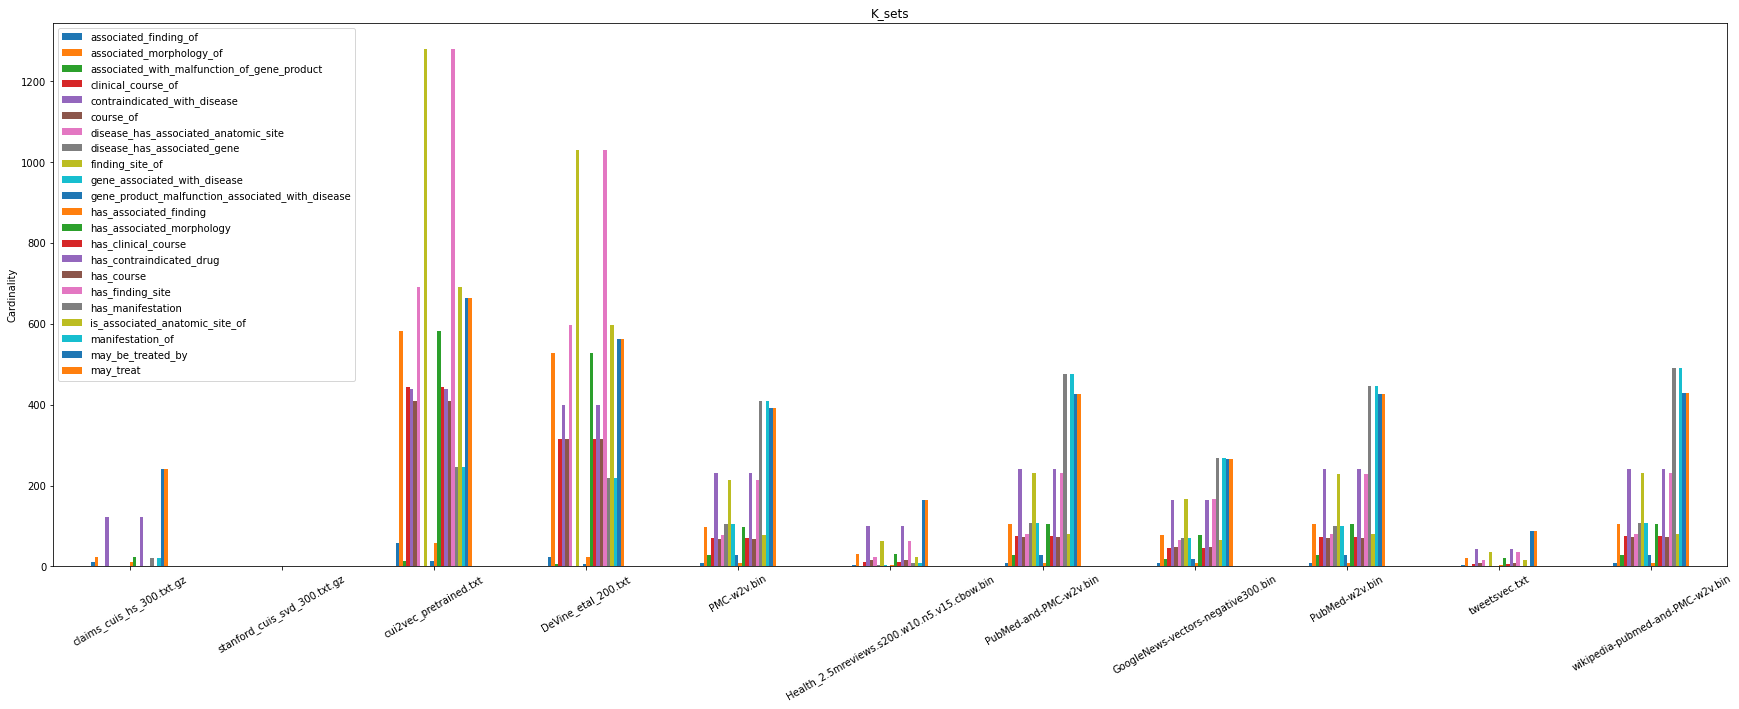

In [18]:
df_list = {}
names = embeddings[0][1]+embeddings[1][1]

plt.rcParams["figure.figsize"] = (30,10)

for rela, i in sets_rels_ordered.items():
    #print(i[1])
    if rela == '':
        break
    df_list[rela] = i[1][:-1]

    
plotdata = pd.DataFrame(df_list, index = names)
plotdata.plot(kind="bar")

plt.title("K_sets")
plt.xticks(rotation = 30)
plt.ylabel("Cardinality")

### Plot L-sets cardinality

Text(0, 0.5, 'Cardinality')

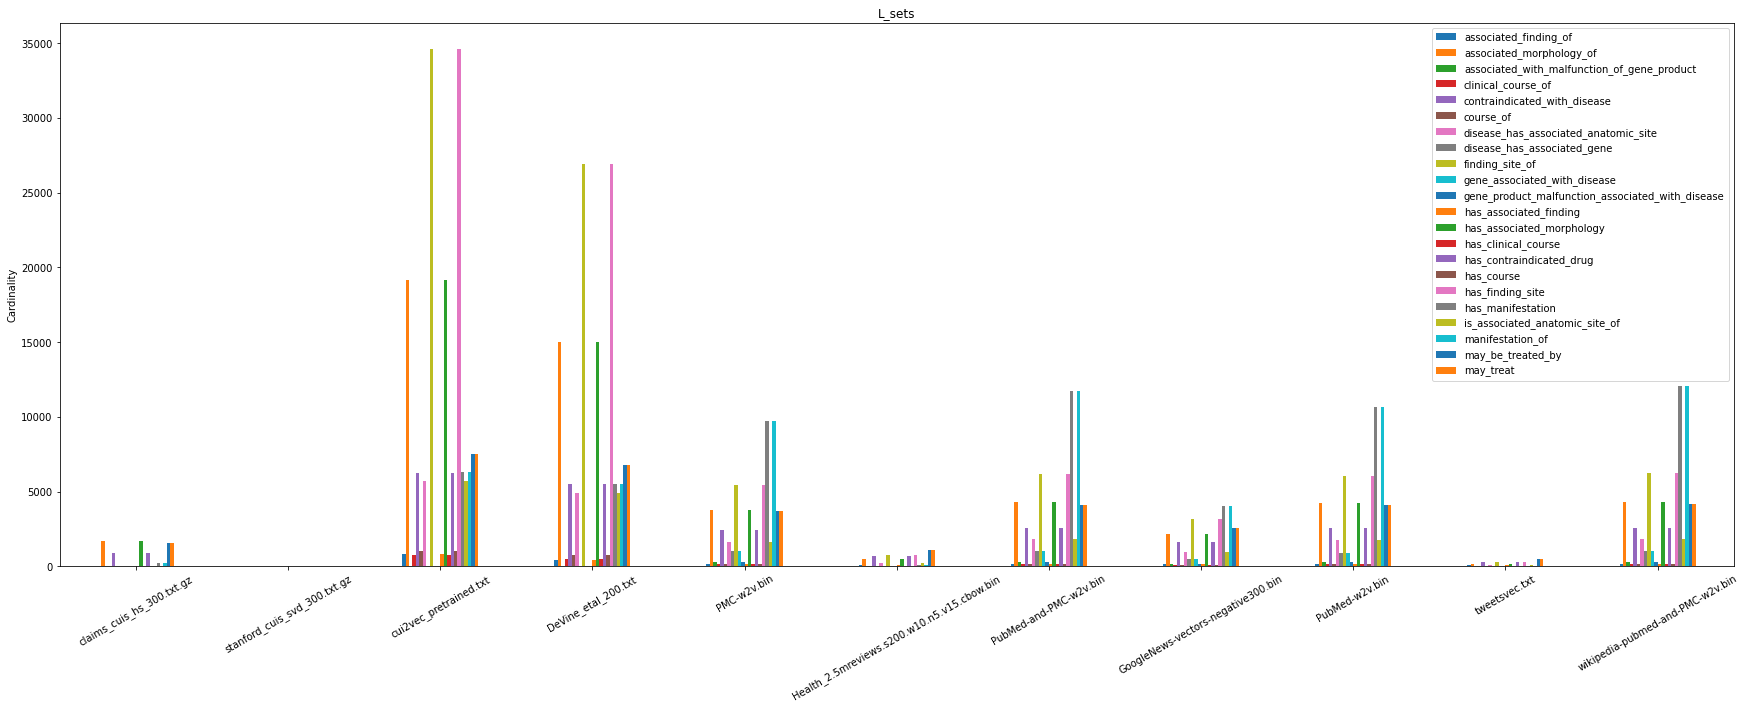

In [19]:
df_list = {}
names = embeddings[0][1]+embeddings[1][1]

for rela, i in sets_rels_ordered.items():
    #print(i[1])
    if rela == '':
        break
    df_list[rela] = i[0][:-1]

    
plotdata = pd.DataFrame(df_list, index = names)
plotdata.plot(kind="bar")

plt.title("L_sets")
plt.xticks(rotation = 30)
plt.ylabel("Cardinality")

### Extracting labels by K_umls_copd pairs, for understanding the semantics of each relations 

In [3]:
#dict_strings = umls_tables_processing.cui_strings()
dict_strings = utils.inputs_load('Utilities/dict_conso')

0:00:15


This print showed how the concepts are related each others in UMLS: they have reverse direction. 

The first element of couple is semantically the second one, which is bounded thanks to a relation to the second element of couple, which is semantically the first one.

The methods in `umls_tables_processing` already compute the reversing operation

In [10]:
for k,v in K_umls_copd.items():
    print(v[0])
    first = list(zip(*v))[0][0] 
    first, _ = umls_tables_processing.extracting_strings([first], dict_strings = dict_strings)
    second = list(zip(*v))[1][0]
    second, _ = umls_tables_processing.extracting_strings([second], dict_strings = dict_strings)
    print(str(list(first.values())[0][0])+ ' ' + k + ' ' + str(list(second.values())[0][0]) + '\n')

('C0024117', 'C0001792')
0:00:00
0:00:00
Chronic Obstructive Airway Disease  Elderly (population group)

('C0024117', 'C0001883')
0:00:00
0:00:00
Chronic Obstructive Airway Disease isa Airway Obstruction

('C0024117', 'C0004096')
0:00:00
0:00:00
Chronic Obstructive Airway Disease related_to ARNASESTUA

('C0024117', 'C0006267')
0:00:00
0:00:00
Chronic Obstructive Airway Disease inverse_isa Bronchiectasis

('C0024117', 'C0006270')
0:00:00
0:00:00
Chronic Obstructive Airway Disease has_finding_site Bronchioles

('C0024117', 'C0024109')
0:00:00
0:00:00
Chronic Obstructive Airway Disease disease_has_associated_anatomic_site Lung

('C0024117', 'C0024117')
0:00:00
0:00:00
Chronic Obstructive Airway Disease see_from Chronic Obstructive Airway Disease

('C0024117', 'C0024117')
0:00:00
0:00:00
Chronic Obstructive Airway Disease entry_version_of Chronic Obstructive Airway Disease

('C0040233', 'C0024117')
0:00:00
0:00:00
timolol contraindicated_with_disease Chronic Obstructive Airway Disease

('C

### A toy example is coded below for our analogy computation:

A CUI embedding is loaded

In [270]:
dv = 'Embeddings/cuis/DeVine_etal_200.txt'

a = datetime.datetime.now().replace(microsecond=0)
model = KeyedVectors.load_word2vec_format(dv, binary=False)
print(datetime.datetime.now().replace(microsecond=0)-a)

0:00:20


In [18]:
rela = 'may_treat'

A random `RELA` is choosen

In [19]:
len(K_umls[rela])

1208

In [20]:
l0, k0 = measures.k_n_l_iov(K_umls[rela], K_umls[rela], model, emb_type = 'cui')

(2, 1208)
L=k
0:00:00
563


With `l0=k0` 

In [19]:
len(l0)==len(k0)

True

In [20]:
print(len(l0))

563


In [21]:
len(l0)*len(l0)

316969

Code lines taken from `analogy_compute` in `measures`

In [22]:
a = datetime.datetime.now().replace(microsecond=0)
storing_list_add = []
storing_list_mul = []
storing_list_dir = []
k_most_similar = 10
eps = 0.0001

for concept_L in l0:
    for concept_K in k0:
        # This check returns a number of analogy computed fewer than the number of starting pairs (K and L)
        if concept_L != concept_K:
            #if len(check)==0:
            storing_list_add = measures.cos3add(concept_L, concept_K, model, k_most_similar, storing_list_add)
            storing_list_mul = measures.cos3mul(concept_L, concept_K, model, storing_list_mul, epsilon = eps)
            storing_list_dir = measures.pair_direction(concept_L, concept_K, model, storing_list_dir, epsilon = eps)

print(datetime.datetime.now().replace(microsecond=0)-a)

0:50:08


Magnitude of 3CosAdd, normalized for the number of computations: it does not correspond to the exact product

The same pairs are discarded

In [23]:
print('The occurrences using 3CosAdd (analogic reasoning), for rela ' +rela+ '  is: '+str(sum(list(zip(*storing_list_add))[2])/len(storing_list_add)))

The occurrences using 3CosAdd (analogic reasoning), for rela may_treat  is: 0.033216816368842564


In [24]:
print('The occurrences using 3CosMul, for rela ' +rela+ '  is: '+str(sum(list(zip(*storing_list_mul))[2])/len(storing_list_mul)))

The occurrences using 3CosMul, for rela may_treat  is: 0.5713659039716059


In [25]:
print('The value of pair_direction, for rela ' +rela+ ' is: '+str(sum(list(zip(*storing_list_dir))[2])/len(storing_list_dir)))

The value of pair_direction, for rela may_treat is: 0.21822307969204216


Try to check in place of `1-distance.cosine` the `model.similarity`, just for coherence: checked

`model.similarity`, the `gensim` method for computing the cosine similarity among words, does not work in this case, because it does not work on vectors, but only on IoV strings. 

The following code is taken by https://github.com/rishibommasani/Contextual2Static in particular way, it is interesting the aspect related to the bias computation, thanks to the usage of PCA first component.

In [7]:
from sklearn.decomposition import PCA
from scipy import spatial

def compute_bias_direction(embeddings, seed_pairs):
    a = datetime.datetime.now().replace(microsecond=0)
    diff_embeddings = [embeddings[x] - embeddings[y] for x,y in seed_pairs]
    X = np.array(diff_embeddings)
    pca = PCA(n_components=1)
    pca.fit(X)
    print(datetime.datetime.now().replace(microsecond=0)-a)
    return pca.components_[0], pca.explained_variance_ratio_[0]

### Opposing relationships are detected

In [269]:
opposites = umls_tables_processing.OPPOSITE_RELAS
opposites

[('associated_finding_of', 'has_associated_finding'),
 ('associated_morphology_of', 'has_associated_morphology'),
 ('associated_with_malfunction_of_gene_product',
  'gene_product_malfunction_associated_with_disease'),
 ('clinical_course_of', 'has_clinical_course'),
 ('contraindicated_with_disease', 'has_contraindicated_drug'),
 ('course_of', 'has_course'),
 ('disease_has_associated_anatomic_site', 'is_associated_anatomic_site_of'),
 ('disease_has_associated_gene', 'gene_associated_with_disease'),
 ('finding_site_of', 'has_finding_site'),
 ('manifestation_of', 'has_manifestation'),
 ('may_treat', 'may_be_treated_by')]

### The idea is evaluating the direction of relationships, inside the embeddings, evaluating two different sets of semantic couple:

In [294]:
len(set(K_umls['has_associated_finding']).difference(set(K_umls['associated_finding_of'])))

246

In [296]:
len((set(K_umls['associated_finding_of'])))

248

In [295]:
len(set(K_umls['has_associated_finding']))

248

Filtering of the two sets with the IoV couples (on DeVine embedding)

In [274]:
k, _ = measures.k_n_l_iov(K_umls['associated_finding_of'], K_umls['associated_finding_of'], model, emb_type = 'cui')

k_opposite, _ = measures.k_n_l_iov(K_umls['has_associated_finding'], K_umls['has_associated_finding'], model, emb_type = 'cui')

l, _ = measures.k_n_l_iov(L_umls['associated_finding_of'], L_umls['associated_finding_of'], model, emb_type = 'cui')

l_opposite, _ = measures.k_n_l_iov(L_umls['has_associated_finding'], L_umls['has_associated_finding'], model, emb_type = 'cui')


(2, 437)
L=k
0:00:00
43
(2, 437)
L=k
0:00:00
43
(2, 12796)
L=k
0:02:57
684
(2, 12796)
L=k
0:00:00
684


At this point we can obtain the L/K set, for the `associated_finding_of` and its opposite `has_associated_finding`:

In [275]:
lk = list(set(l).difference(set(k)))
lko = list(set(l_opposite).difference(set(k_opposite)))

#### We basically obtained -theoretically- unrelated sets, a futher check would be checking the concepts of the pairs. 

- Finding the first component via PCA of the difference of each vectors-couple in the L/K set, for the regular and opposite relation.

In [276]:
lk_dir = np.array(measures.relation_direction(model,lk)).reshape(1,-1)
lko_dir = np.array(measures.relation_direction(model,lko)).reshape(1,-1)

0:00:00
0:00:00


- Finding the first component via PCA of the difference of each vectors-couple in the K set, for the regular and opposite relation.

In [277]:
k_dir = np.array(measures.relation_direction(model,k)).reshape(1,-1)
ko_dir = np.array(measures.relation_direction(model,k_opposite)).reshape(1,-1)

0:00:00
0:00:00


- Calculate the cosine similarity between the two directions vector obtained, one for L/K and the other for K.

In [304]:
from scipy.spatial.distance import cdist

1. - cdist(lk_dir, k_dir, 'cosine')[0][0]

-0.7139773681017139

This is a value I expected computing the distance among the direction of L/K for regular relation and the opposite of the same in K, not on the same "direction" of semantic relation.

Indeed:

In [305]:
print('For the same direction: '+str(1. - cdist(lk_dir, lk_dir, 'cosine')[0][0]))
print('For opposite direction: '+str(1. - cdist(lk_dir, lko_dir, 'cosine')[0][0]))

For the same direction: 1.0
For opposite direction: -0.9999999999999656


In [289]:
1. - cdist(lk_dir, ko_dir, 'cosine')[0][0]

0.713977232614876

In [290]:
1. - cdist(lko_dir, k_dir, 'cosine')[0][0]

0.7139773512895904

In [297]:
1. - cdist(lko_dir, ko_dir, 'cosine')[0][0]

-0.7139772158027786

### Rebrief of the pipeline:

- Finding the first component via PCA of the L / K set for a specific relation, and filtering IoV the result.
- Finding the first component via PCA of the K set for the same specific relation, and filtering IoV the result.
- Calculate the cosine similarity among the two vectors which represent the same rela on two different set.

### Plotting analogical pipeline data

In [2]:
data_to_plot = utils.inputs_load('Utilities/Analogical Data/claims_cuis_hs_300.txt_LsameasK_umls')
data_to_plot_ = utils.inputs_load('Utilities/Analogical Data/cui2vec_pretrained_LsameasK_umls')
data_to_plot__ = utils.inputs_load('Utilities/Analogical Data/DeVine_etal_200_LsameasK_umls')

0:00:01
0:00:47
0:00:38


More usable dictionaries:

In [64]:
dict_add = {}
dict_mul = {}
dict_pair = {}
dicts = [data_to_plot, data_to_plot_, data_to_plot__]
for dict_ in dicts:
    print(dict_.keys())
    for embeddings,v in dict_.items():
        print(embeddings)
        dict_add[embeddings] = {}
        dict_mul[embeddings] = {}
        dict_pair[embeddings] = {}
        for rela, operations in v.items():
            if len(list(operations.keys()))>0:
                tmp_add = [sum(operations['add']), len(operations['add'])]
                tmp_mul = utils.aggregation_values(operations['mul'])
                tmp_pair = utils.aggregation_values(operations['pair'])
            else:
                tmp_add = 0
                tmp_mul = 0
                tmp_pair = 0
            dict_add[embeddings][rela] = tmp_add
            dict_mul[embeddings][rela] = tmp_mul
            dict_pair[embeddings][rela] = tmp_pair

                

dict_keys(['claims_cuis_hs_300.txt'])
claims_cuis_hs_300.txt
dict_keys(['cui2vec_pretrained'])
cui2vec_pretrained
dict_keys(['DeVine_etal_200'])
DeVine_etal_200


### Plotting 3CosAdd data

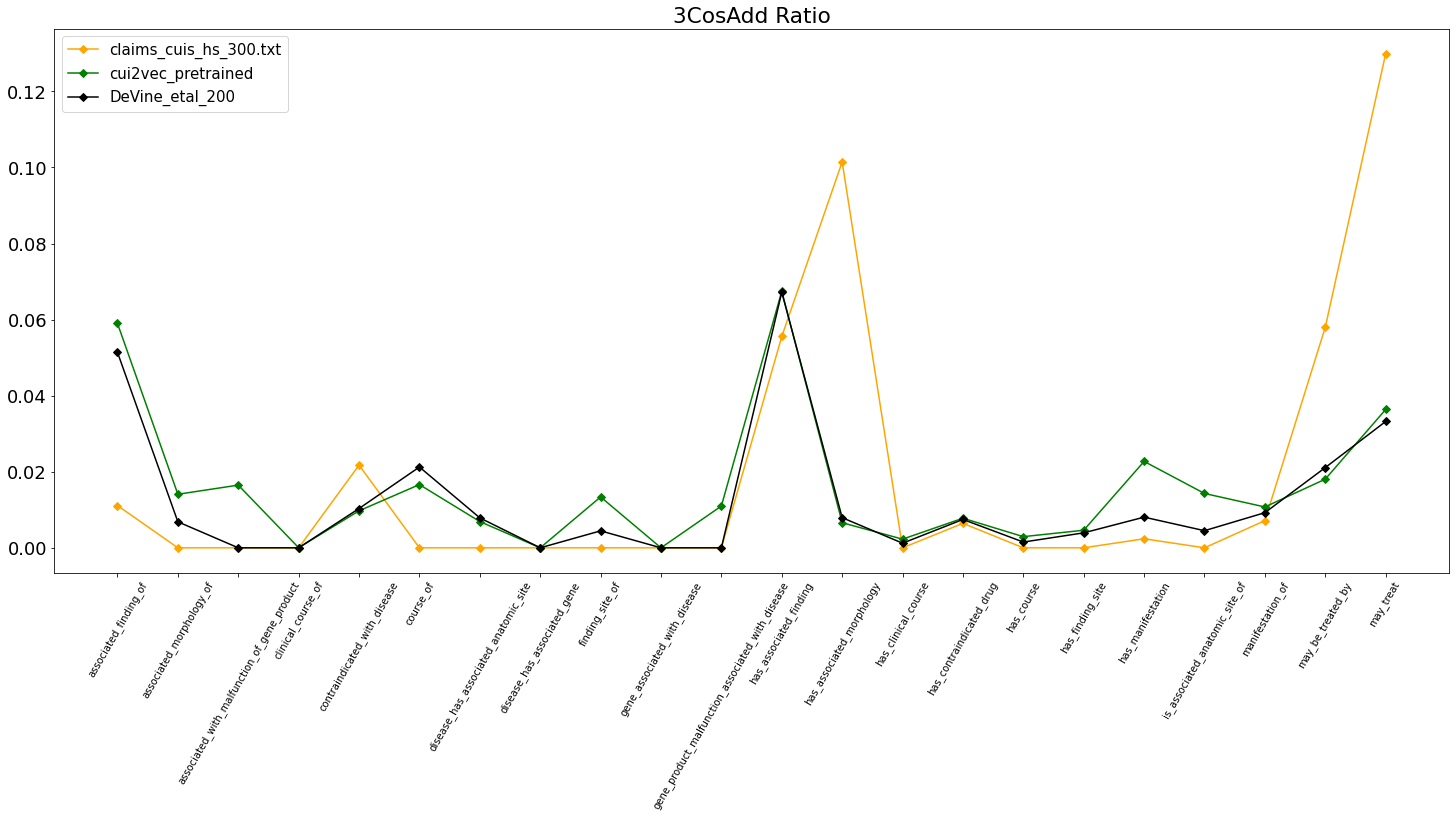

In [121]:
fig, ax = plt.subplots(figsize=(25,10))
count_claim = list(list(zip(*[[0]*2 if i == 0 else i for i in list(list(dict_add.values())[0].values())]))[0])
length_claim = list(list(zip(*[[0]*2 if i == 0 else i for i in list(list(dict_add.values())[0].values())]))[1])
count_cui2vec = list(list(zip(*[[0]*2 if i == 0 else i for i in list(list(dict_add.values())[1].values())]))[0])
length_cui2vec = list(list(zip(*[[0]*2 if i == 0 else i for i in list(list(dict_add.values())[1].values())]))[1])
count_devine = list(list(zip(*[[0]*2 if i == 0 else i for i in list(list(dict_add.values())[2].values())]))[0])
length_devine = list(list(zip(*[[0]*2 if i == 0 else i for i in list(list(dict_add.values())[2].values())]))[1])

count = [count_claim, count_cui2vec, count_devine]
length = [length_claim, length_cui2vec, length_devine]

ax.set_title('3CosAdd Ratio')
ax.plot(np.arange(0, len(list(dict_add.values())[0])), np.array([0 if i ==0 else i/length_claim[n] for n, i in enumerate(count_claim)]), '-gD',color = 'orange', label = list(dict_add.keys())[0])
ax.plot(np.arange(0, len(list(dict_add.values())[1])), np.array([0 if i ==0 else i/length_cui2vec[n] for n, i in enumerate(count_cui2vec)]), '-gD',color = 'green', label = list(dict_add.keys())[1])
ax.plot(np.arange(0, len(list(dict_add.values())[2])), np.array([0 if i ==0 else i/length_devine[n] for n, i in enumerate(count_devine)]), '-gD',color = 'black', label = list(dict_add.keys())[2])
ax.set_xticks(np.arange(0, len(list(dict_add.values())[0])))
ax.set_xticklabels(np.array(list(list(dict_add.values())[0])), rotation=60, fontsize=10)
ax.legend(fontsize=15)


### Plotting 3CosMul data

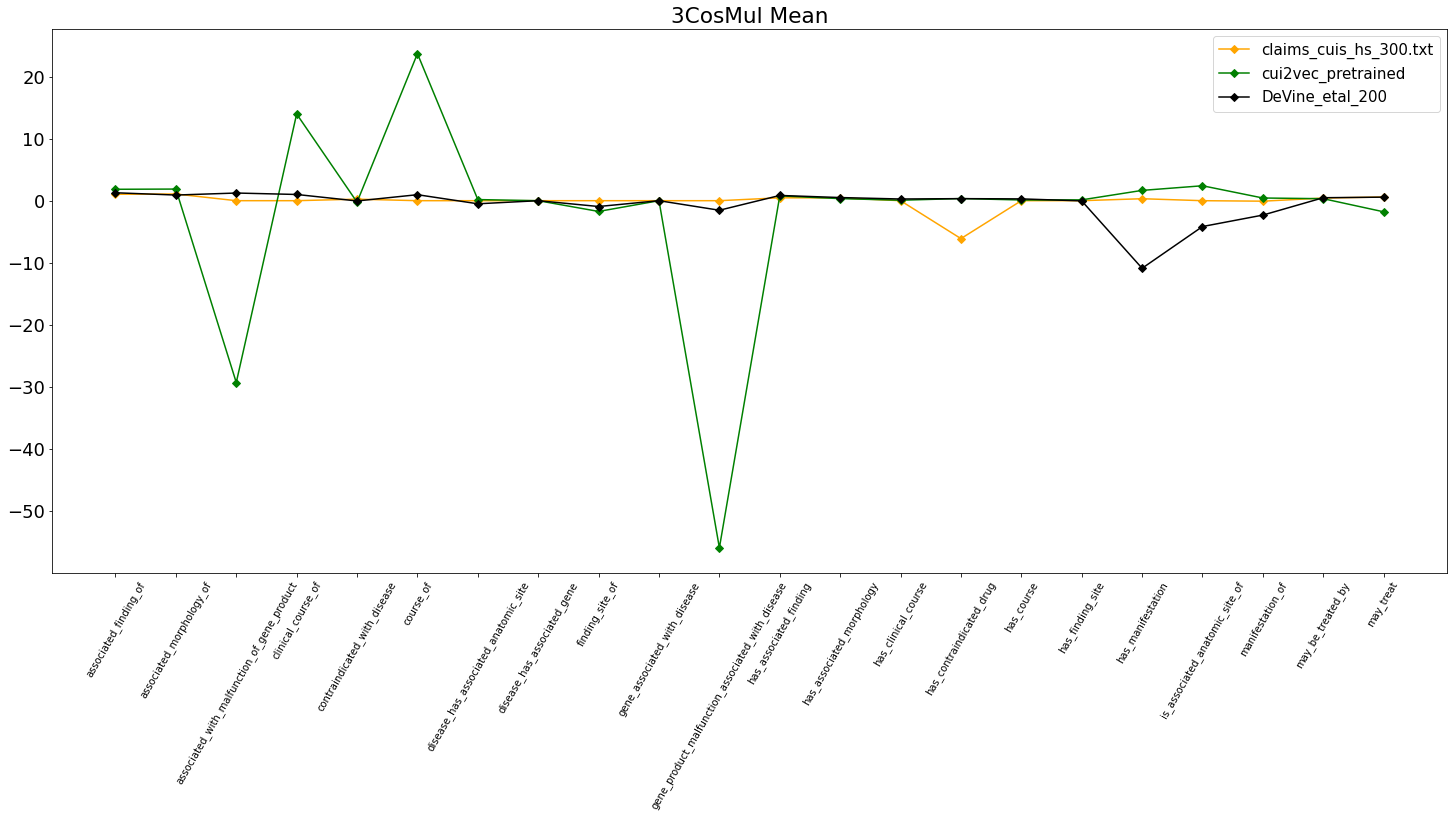

In [119]:
plt.rcParams.update({'font.size': 18})

fig, ax1 = plt.subplots(figsize=(25,10))
ax1.set_title('3CosMul Mean')

#ax1.plot(np.arange(0, len(dict_add)), np.array(list(dict_add.values())), dashes = '.', color = 'orange')
ax1.plot(np.arange(0, len(list(dict_mul.values())[0])), np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[0].values())]))[2]), '-gD',color = 'orange', label = list(dict_mul.keys())[0])

ax1.plot(np.arange(0, len(list(dict_mul.values())[1])), np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[1].values())]))[2]), '-gD',color = 'green', label = list(dict_mul.keys())[1])

ax1.plot(np.arange(0, len(list(dict_mul.values())[2])), np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[2].values())]))[2]), '-gD',color = 'black', label = list(dict_mul.keys())[2])

ax1.set_xticks(np.arange(0, len(list(dict_mul.values())[0])))
ax1.set_xticklabels(np.array(list(list(dict_mul.values())[0])), rotation=60, fontsize=10)
ax1.legend(fontsize=15)

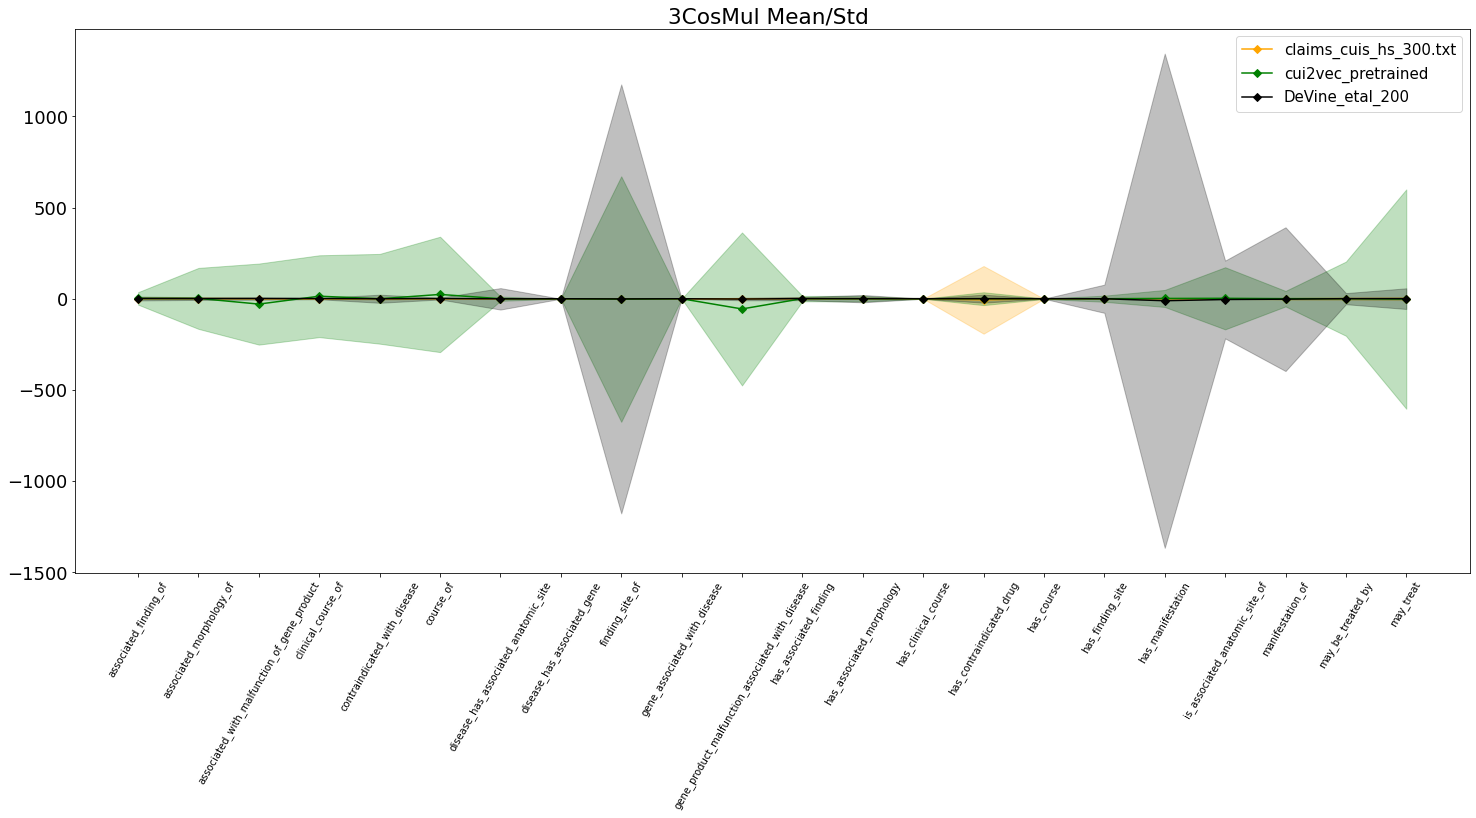

In [53]:
plt.rcParams.update({'font.size': 18})

fig, ax1 = plt.subplots(figsize=(25,10))
ax1.set_title('3CosMul Mean/Std ')

#ax1.plot(np.arange(0, len(dict_add)), np.array(list(dict_add.values())), dashes = '.', color = 'orange')
ax1.plot(np.arange(0, len(list(dict_mul.values())[0])), np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[0].values())]))[2]), '-gD',color = 'orange', label = list(dict_mul.keys())[0])
ax1.fill_between(np.arange(0, len(list(dict_mul.values())[0])),
                 (np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[0].values())]))[2])-
                  np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[0].values())]))[3])), 
                 (np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[0].values())]))[2])+
                  np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[0].values())]))[3])), 
                 color='orange', alpha = 0.25)

ax1.plot(np.arange(0, len(list(dict_mul.values())[1])), np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[1].values())]))[2]), '-gD',color = 'green', label = list(dict_mul.keys())[1])
ax1.fill_between(np.arange(0, len(list(dict_mul.values())[1])),
                 (np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[1].values())]))[2])-
                  np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[1].values())]))[3])), 
                 (np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[1].values())]))[2])+
                  np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[1].values())]))[3])), 
                 color='green', alpha = 0.25)

ax1.plot(np.arange(0, len(list(dict_mul.values())[2])), np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[2].values())]))[2]), '-gD',color = 'black', label = list(dict_mul.keys())[2])
ax1.fill_between(np.arange(0, len(list(dict_mul.values())[2])),
                 (np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[2].values())]))[2])-
                  np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[2].values())]))[3])), 
                 (np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[2].values())]))[2])+
                  np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[2].values())]))[3])), 
                 color='black', alpha = 0.25)

ax1.set_xticks(np.arange(0, len(list(dict_mul.values())[0])))
ax1.set_xticklabels(np.array(list(list(dict_mul.values())[0])), rotation=60, fontsize=10)
ax1.legend(fontsize=15)

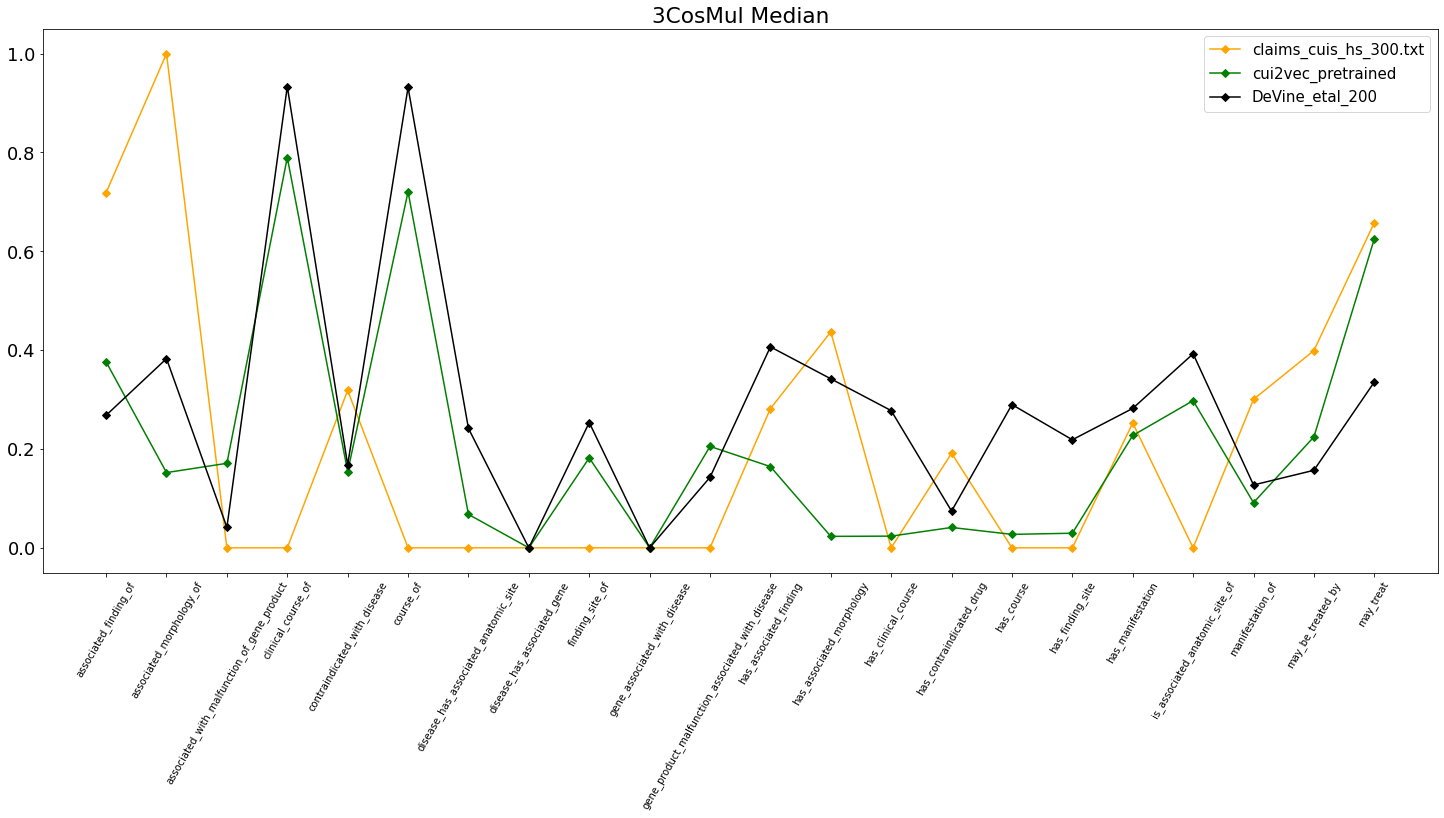

In [54]:
plt.rcParams.update({'font.size': 18})

fig, ax1 = plt.subplots(figsize=(25,10))
ax1.set_title('3CosMul Median')

#ax1.plot(np.arange(0, len(dict_add)), np.array(list(dict_add.values())), dashes = '.', color = 'orange')
ax1.plot(np.arange(0, len(list(dict_mul.values())[0])), np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[0].values())]))[6]), '-gD',color = 'orange', label = list(dict_mul.keys())[0])

ax1.plot(np.arange(0, len(list(dict_mul.values())[1])), np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[1].values())]))[6]), '-gD',color = 'green', label = list(dict_mul.keys())[1])

ax1.plot(np.arange(0, len(list(dict_mul.values())[2])), np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[2].values())]))[6]), '-gD',color = 'black', label = list(dict_mul.keys())[2])

ax1.set_xticks(np.arange(0, len(list(dict_mul.values())[0])))
ax1.set_xticklabels(np.array(list(list(dict_mul.values())[0])), rotation=60, fontsize=10)
ax1.legend(fontsize=15)

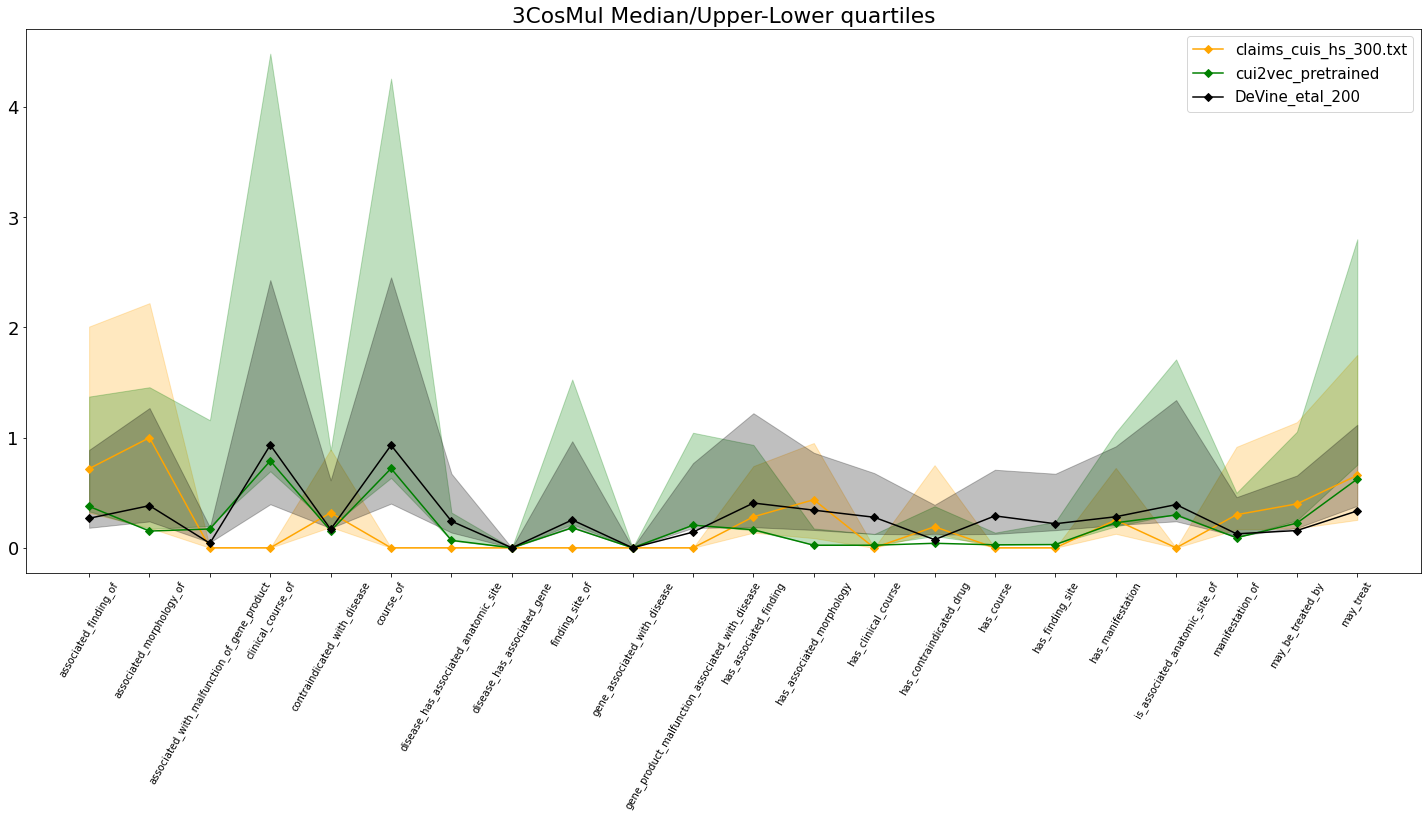

In [55]:
plt.rcParams.update({'font.size': 18})

fig, ax1 = plt.subplots(figsize=(25,10))
ax1.set_title('3CosMul Median/Upper-Lower quartiles')

#ax1.plot(np.arange(0, len(dict_add)), np.array(list(dict_add.values())), dashes = '.', color = 'orange')
ax1.plot(np.arange(0, len(list(dict_mul.values())[0])), np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[0].values())]))[6]), '-gD',color = 'orange', label = list(dict_mul.keys())[0])
ax1.fill_between(np.arange(0, len(list(dict_mul.values())[0])),
                 (np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[0].values())]))[6])-
                  np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[0].values())]))[5])), 
                 (np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[0].values())]))[6])+
                  np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[0].values())]))[7])), 
                 color='orange', alpha = 0.25)

ax1.plot(np.arange(0, len(list(dict_mul.values())[1])), np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[1].values())]))[6]), '-gD',color = 'green', label = list(dict_mul.keys())[1])
ax1.fill_between(np.arange(0, len(list(dict_mul.values())[1])),
                 (np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[1].values())]))[6])-
                  np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[1].values())]))[5])), 
                 (np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[1].values())]))[6])+
                  np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[1].values())]))[7])), 
                 color='green', alpha = 0.25)

ax1.plot(np.arange(0, len(list(dict_mul.values())[2])), np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[2].values())]))[6]), '-gD',color = 'black', label = list(dict_mul.keys())[2])
ax1.fill_between(np.arange(0, len(list(dict_mul.values())[2])),
                 (np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[2].values())]))[6])-
                  np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[2].values())]))[5])), 
                 (np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[2].values())]))[6])+
                  np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_mul.values())[2].values())]))[7])), 
                 color='black', alpha = 0.25)

ax1.set_xticks(np.arange(0, len(list(dict_mul.values())[0])))
ax1.set_xticklabels(np.array(list(list(dict_mul.values())[0])), rotation=60, fontsize=10)
ax1.legend(fontsize=15)

### Plotting Pair-Direction data

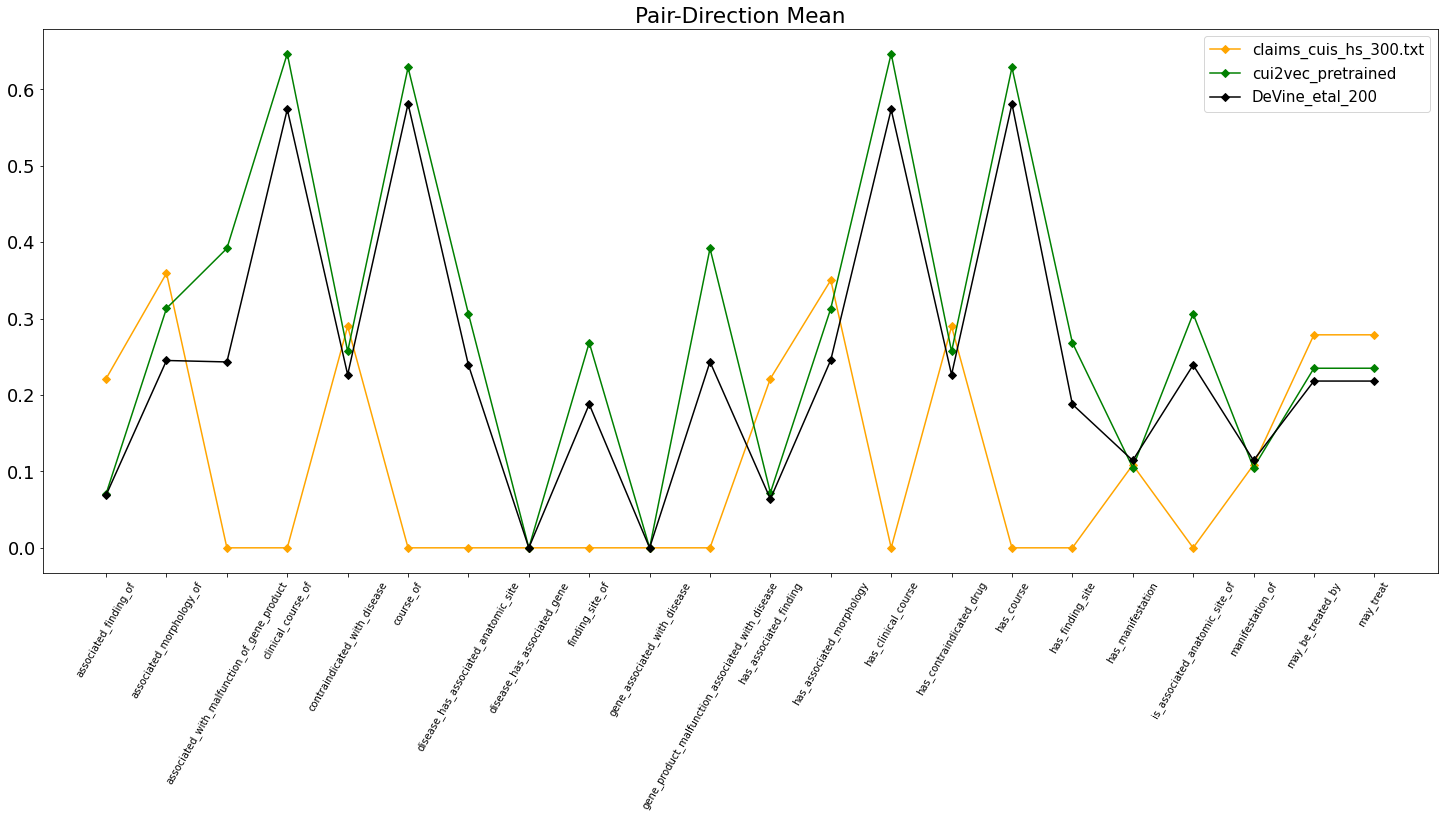

In [56]:
plt.rcParams.update({'font.size': 18})

fig, ax1 = plt.subplots(figsize=(25,10))
ax1.set_title('Pair-Direction Mean')

#ax1.plot(np.arange(0, len(dict_add)), np.array(list(dict_add.values())), dashes = '.', color = 'orange')
ax1.plot(np.arange(0, len(list(dict_pair.values())[0])), np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[0].values())]))[2]), '-gD',color = 'orange', label = list(dict_pair.keys())[0])

ax1.plot(np.arange(0, len(list(dict_pair.values())[1])), np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[1].values())]))[2]), '-gD',color = 'green', label = list(dict_pair.keys())[1])

ax1.plot(np.arange(0, len(list(dict_pair.values())[2])), np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[2].values())]))[2]), '-gD',color = 'black', label = list(dict_pair.keys())[2])

ax1.set_xticks(np.arange(0, len(list(dict_pair.values())[0])))
ax1.set_xticklabels(np.array(list(list(dict_pair.values())[0])), rotation=60, fontsize=10)
ax1.legend(fontsize=15)

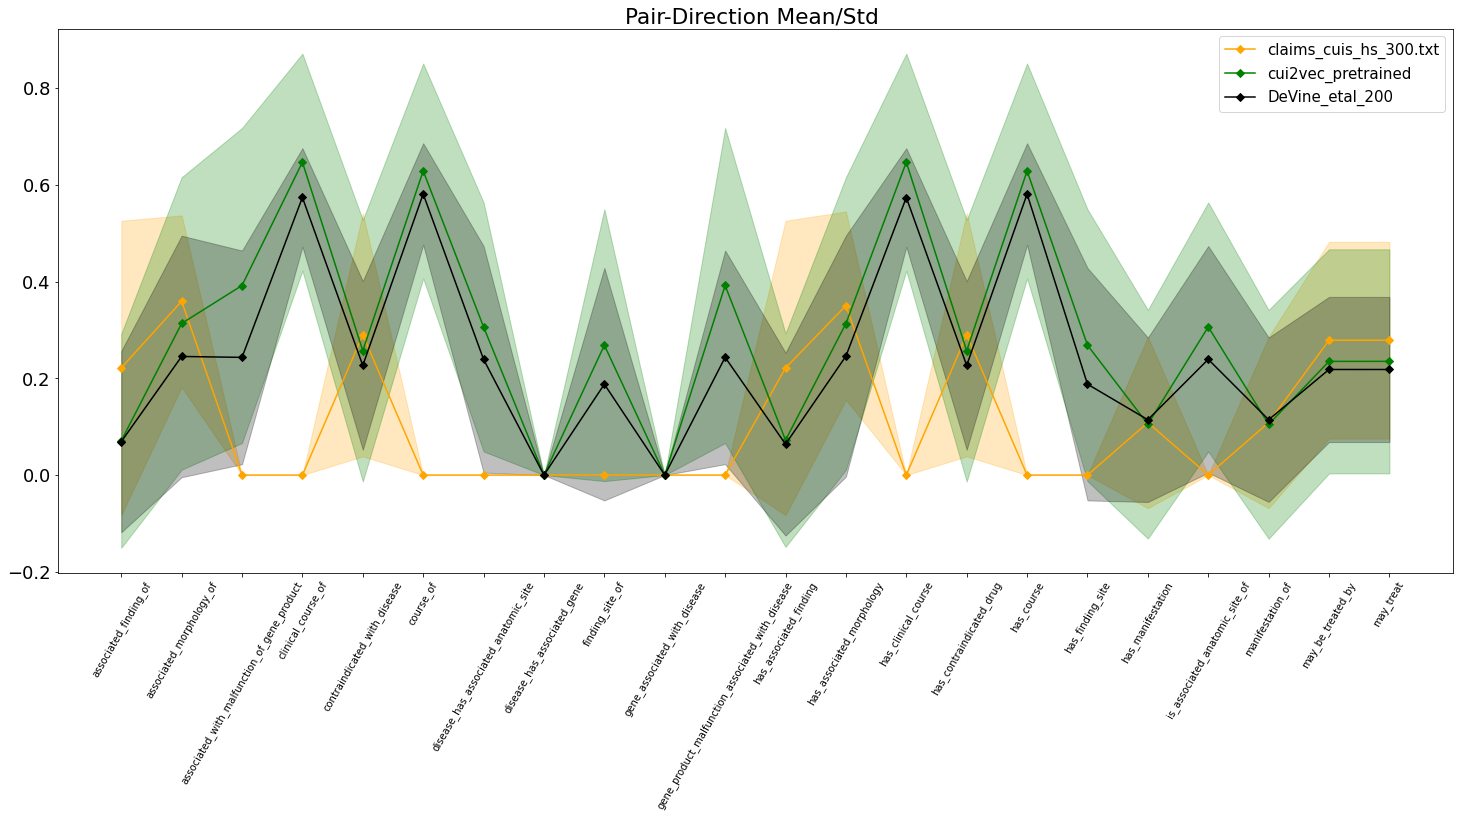

In [58]:
plt.rcParams.update({'font.size': 18})

fig, ax1 = plt.subplots(figsize=(25,10))
ax1.set_title('Pair-Direction Mean/Std ')

#ax1.plot(np.arange(0, len(dict_add)), np.array(list(dict_add.values())), dashes = '.', color = 'orange')
ax1.plot(np.arange(0, len(list(dict_pair.values())[0])), np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[0].values())]))[2]), '-gD',color = 'orange', label = list(dict_pair.keys())[0])
ax1.fill_between(np.arange(0, len(list(dict_pair.values())[0])),
                 (np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[0].values())]))[2])-
                  np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[0].values())]))[3])), 
                 (np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[0].values())]))[2])+
                  np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[0].values())]))[3])), 
                 color='orange', alpha = 0.25)

ax1.plot(np.arange(0, len(list(dict_pair.values())[1])), np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[1].values())]))[2]), '-gD',color = 'green', label = list(dict_pair.keys())[1])
ax1.fill_between(np.arange(0, len(list(dict_pair.values())[1])),
                 (np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[1].values())]))[2])-
                  np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[1].values())]))[3])), 
                 (np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[1].values())]))[2])+
                  np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[1].values())]))[3])), 
                 color='green', alpha = 0.25)

ax1.plot(np.arange(0, len(list(dict_pair.values())[2])), np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[2].values())]))[2]), '-gD',color = 'black', label = list(dict_pair.keys())[2])
ax1.fill_between(np.arange(0, len(list(dict_pair.values())[2])),
                 (np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[2].values())]))[2])-
                  np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[2].values())]))[3])), 
                 (np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[2].values())]))[2])+
                  np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[2].values())]))[3])), 
                 color='black', alpha = 0.25)

ax1.set_xticks(np.arange(0, len(list(dict_pair.values())[0])))
ax1.set_xticklabels(np.array(list(list(dict_pair.values())[0])), rotation=60, fontsize=10)
ax1.legend(fontsize=15)

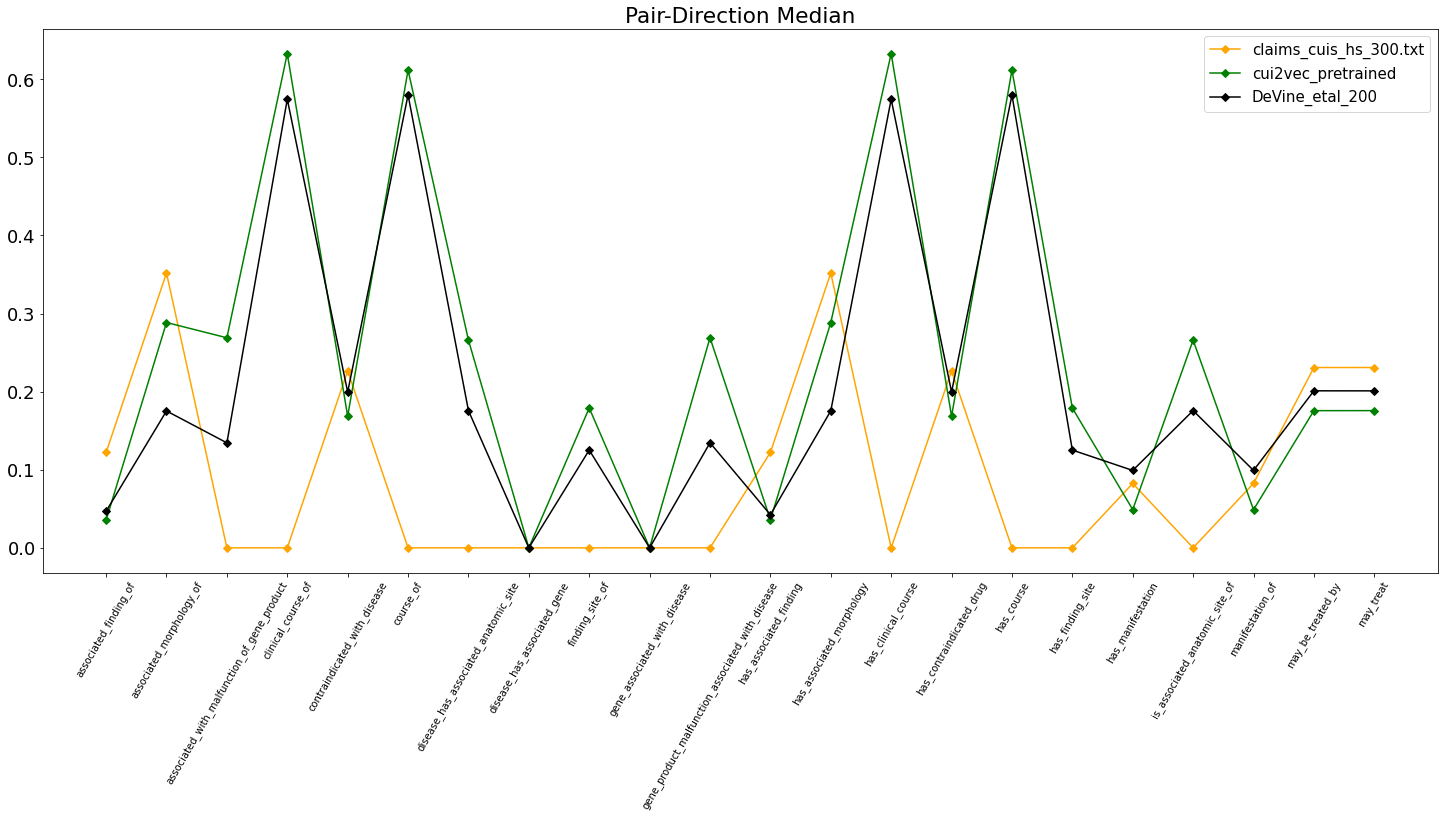

In [61]:
plt.rcParams.update({'font.size': 18})

fig, ax1 = plt.subplots(figsize=(25,10))
ax1.set_title('Pair-Direction Median')

#ax1.plot(np.arange(0, len(dict_add)), np.array(list(dict_add.values())), dashes = '.', color = 'orange')
ax1.plot(np.arange(0, len(list(dict_pair.values())[0])), np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[0].values())]))[6]), '-gD',color = 'orange', label = list(dict_pair.keys())[0])

ax1.plot(np.arange(0, len(list(dict_pair.values())[1])), np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[1].values())]))[6]), '-gD',color = 'green', label = list(dict_pair.keys())[1])

ax1.plot(np.arange(0, len(list(dict_pair.values())[2])), np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[2].values())]))[6]), '-gD',color = 'black', label = list(dict_pair.keys())[2])

ax1.set_xticks(np.arange(0, len(list(dict_pair.values())[0])))
ax1.set_xticklabels(np.array(list(list(dict_pair.values())[0])), rotation=60, fontsize=10)
ax1.legend(fontsize=15)

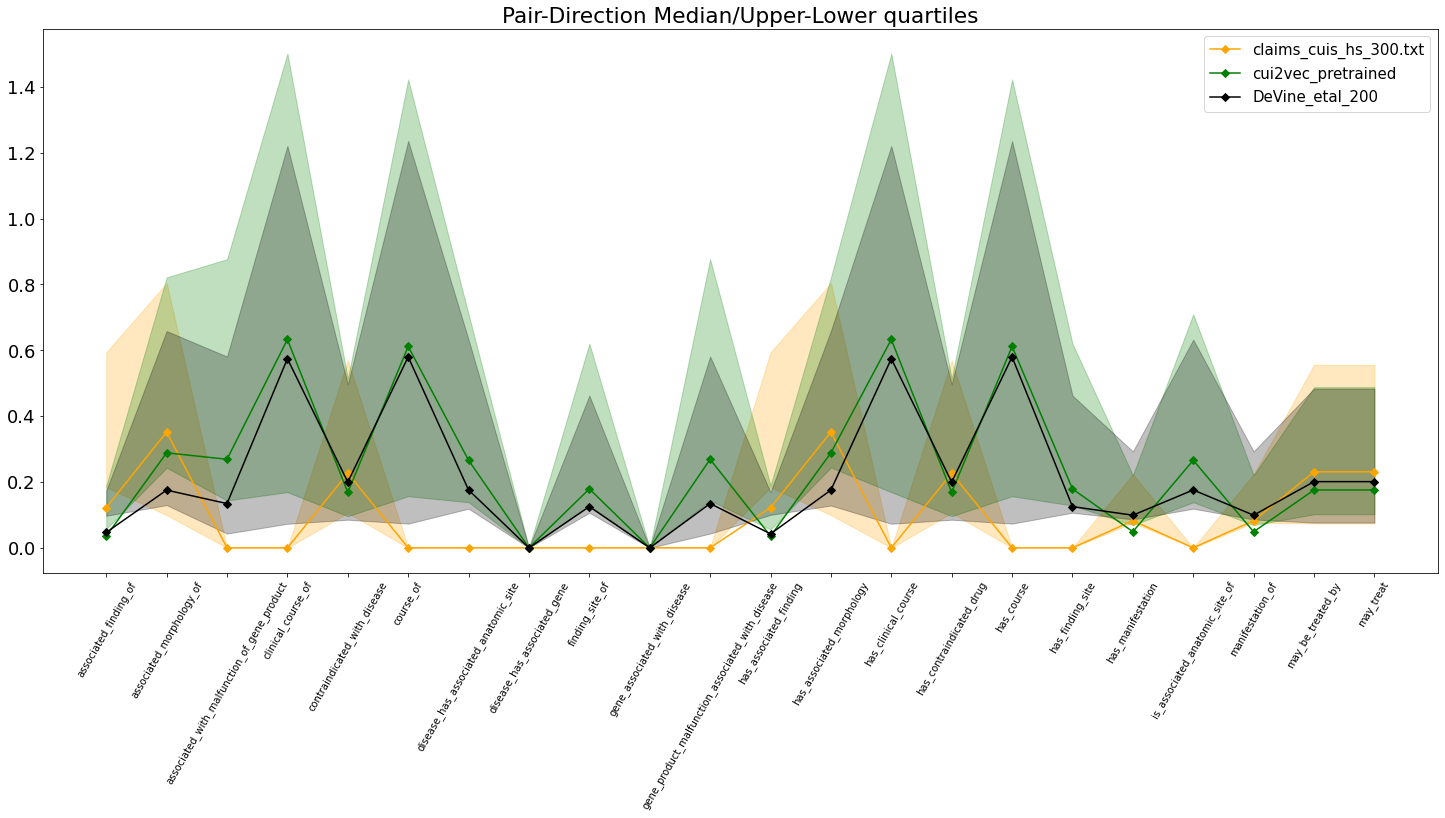

In [59]:
plt.rcParams.update({'font.size': 18})

fig, ax1 = plt.subplots(figsize=(25,10))
ax1.set_title('Pair-Direction Median/Upper-Lower quartiles')

#ax1.plot(np.arange(0, len(dict_add)), np.array(list(dict_add.values())), dashes = '.', color = 'orange')
ax1.plot(np.arange(0, len(list(dict_pair.values())[0])), np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[0].values())]))[6]), '-gD',color = 'orange', label = list(dict_pair.keys())[0])
ax1.fill_between(np.arange(0, len(list(dict_pair.values())[0])),
                 (np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[0].values())]))[6])-
                  np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[0].values())]))[5])), 
                 (np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[0].values())]))[6])+
                  np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[0].values())]))[7])), 
                 color='orange', alpha = 0.25)

ax1.plot(np.arange(0, len(list(dict_pair.values())[1])), np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[1].values())]))[6]), '-gD',color = 'green', label = list(dict_pair.keys())[1])
ax1.fill_between(np.arange(0, len(list(dict_pair.values())[1])),
                 (np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[1].values())]))[6])-
                  np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[1].values())]))[5])), 
                 (np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[1].values())]))[6])+
                  np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[1].values())]))[7])), 
                 color='green', alpha = 0.25)

ax1.plot(np.arange(0, len(list(dict_pair.values())[2])), np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[2].values())]))[6]), '-gD',color = 'black', label = list(dict_pair.keys())[2])
ax1.fill_between(np.arange(0, len(list(dict_pair.values())[2])),
                 (np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[2].values())]))[6])-
                  np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[2].values())]))[5])), 
                 (np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[2].values())]))[6])+
                  np.array(list(zip(*[[0]*9 if i == 0 else i for i in list(list(dict_pair.values())[2].values())]))[7])), 
                 color='black', alpha = 0.25)

ax1.set_xticks(np.arange(0, len(list(dict_pair.values())[0])))
ax1.set_xticklabels(np.array(list(list(dict_pair.values())[0])), rotation=60, fontsize=10)
ax1.legend(fontsize=15)

### Tabled data

In [257]:
df_ks = []
names = list(dict_add.keys())
relas = np.array(list(list(dict_add.values())[0]))
header = [np.array(['3CosAdd']*9),
          np.array([names[0],names[0],names[0],
                    names[1],names[1], names[1],
                    names[2],names[2], names[2]]),
          np.array(['Occurrence', '#Normalization', 'Ratio']*3)] 

tmp = [['%.i'%(q),
        '%.i'%(w),
        '%.3f'%(q/w)] if (q != 0 and w!= 0) 
       else ['%.i'%(q),
             '%.i'%(w),
             '%.3f'%(0)]  
       for c, l in zip(np.transpose(count), np.transpose(length)) for q, w in zip(c, l)]

df_ks.append(pd.DataFrame(np.reshape(tmp, (len(relas), 9)), index=relas, columns = header))
    

In [258]:
df_ks[0]

3CosAdd  \
                                                 claims_cuis_hs_300.txt   
                                                             Occurrence   
associated_finding_of                                                 1   
associated_morphology_of                                              0   
associated_with_malfunction_of_gene_product                           0   
clinical_course_of                                                    0   
contraindicated_with_disease                                        321   
course_of                                                             0   
disease_has_associated_anatomic_site                                  0   
disease_has_associated_gene                                           0   
finding_site_of                                                       0   
gene_associated_with_disease                                          0   
gene_product_malfunction_associated_with_disease                      0   
has_associated_finding                                                5   
has_associated_morphology                                            56   
has_clinical_course                                                   0   
has_contraindicated_drug                                             95   
has_course                                                            0   
has_finding_site                                                      0   
has_manifestation                                                     1   
is_associated_anatomic_site_of                                        0   
manifestation_of                                                      3   
may_be_treated_by                                                  3326   
may_treat                                                          7452   

                                                                        \
                                                                         
                                                 #Normalization  Ratio   
associated_finding_of                                        90  0.011   
associated_morphology_of                                    552  0.000   
associated_with_malfunction_of_gene_product                   0  0.000   
clinical_course_of                                            0  0.000   
contraindicated_with_disease                              14762  0.022   
course_of                                                     0  0.000   
disease_has_associated_anatomic_site                          0  0.000   
disease_has_associated_gene                                   0  0.000   
finding_site_of                                               0  0.000   
gene_associated_with_disease                                  0  0.000   
gene_product_malfunction_associated_with_disease              0  0.000   
has_associated_finding                                       90  0.056   
has_associated_morphology                                   552  0.101   
has_clinical_course                                           0  0.000   
has_contraindicated_drug                                  14762  0.006   
has_course                                                    0  0.000   
has_finding_site                                              0  0.000   
has_manifestation                                           420  0.002   
is_associated_anatomic_site_of                                0  0.000   
manifestation_of                                            420  0.007   
may_be_treated_by                                         57360  0.058   
may_treat                                                 57360  0.130   

                                                                     \
                                                 cui2vec_pretrained   
                                                         Occurrence   
associated_finding_of                                           195   
associated_morphology_of                             

In [259]:
# return [maximum, minumum, mean, std_dev, mode, lower_quart, median, upper_quart, len(values_to_aggregate)]

embeddings = list(dict_mul.keys())
relas = np.array(list(list(dict_mul.values())[0]))

header = [np.array(['3CosMul']*18),
          np.array([embeddings[0],embeddings[0],embeddings[0],embeddings[0],embeddings[0],embeddings[0],#embeddings[0],embeddings[0],embeddings[0],
                    embeddings[1],embeddings[1],embeddings[1],embeddings[1],embeddings[1],embeddings[1],#embeddings[1],embeddings[1],embeddings[1],
                    embeddings[2],embeddings[2],embeddings[2],embeddings[2],embeddings[2],embeddings[2]]),#,embeddings[2],embeddings[2],embeddings[2]]),
          np.array(['Mean', 
                    'Std-Dev', 
                    'Low quartile',
                    'Median', 
                    'Up quartile',
                    '#Aggregated values']*3)] 

tmp = [[#'%.3f'%(dict_mul[emb][rela][0]),
        #'%.3f'%(dict_mul[emb][rela][1]),
        '%.3f'%(dict_mul[emb][rela][2]),
        '%.3f'%(dict_mul[emb][rela][3]),
        #'%.3f'%(dict_mul[emb][rela][4]),
        '%.3f'%(dict_mul[emb][rela][5]),
        '%.3f'%(dict_mul[emb][rela][6]),
        '%.3f'%(dict_mul[emb][rela][7]),
        '%.i'%(dict_mul[emb][rela][8])] if (dict_mul[emb][rela] != 0) 
       else [#'%.i'%(0),
             #'%.i'%(0),
             #'%.i'%(0),
             '%.i'%(0),
             '%.i'%(0),
             '%.i'%(0),
             '%.i'%(0),
             '%.i'%(0),
             '%.i'%(0)]  
       for rela in relas for emb in embeddings]

df_ks.append(pd.DataFrame(np.reshape(tmp, (len(relas), 18)), index=relas, columns = header))
    

In [260]:
df_ks[1]

3CosMul  \
                                                 claims_cuis_hs_300.txt   
                                                                   Mean   
associated_finding_of                                             1.038   
associated_morphology_of                                          1.077   
associated_with_malfunction_of_gene_product                           0   
clinical_course_of                                                    0   
contraindicated_with_disease                                      0.248   
course_of                                                             0   
disease_has_associated_anatomic_site                                  0   
disease_has_associated_gene                                           0   
finding_site_of                                                       0   
gene_associated_with_disease                                          0   
gene_product_malfunction_associated_with_disease                      0   
has_associated_finding                                            0.465   
has_associated_morphology                                         0.450   
has_clinical_course                                                   0   
has_contraindicated_drug                                         -6.110   
has_course                                                            0   
has_finding_site                                                      0   
has_manifestation                                                 0.317   
is_associated_anatomic_site_of                                        0   
manifestation_of                                                 -0.079   
may_be_treated_by                                                 0.423   
may_treat                                                         0.593   

                                                                               \
                                                                                
                                                  Std-Dev Low quartile Median   
associated_finding_of                               0.961        0.401  0.719   
associated_morphology_of                            0.462        0.818  1.000   
associated_with_malfunction_of_gene_product             0            0      0   
clinical_course_of                                      0            0      0   
contraindicated_with_disease                        4.663        0.129  0.318   
course_of                                               0            0      0   
disease_has_associated_anatomic_site                    0            0      0   
disease_has_associated_gene                             0            0      0   
finding_site_of                                         0            0      0   
gene_associated_with_disease                            0            0      0   
gene_product_malfunction_associated_with_disease        0            0      0   
has_associated_finding                              0.572        0.144  0.282   
has_associated_morphology                           0.139        0.349  0.437   
has_clinical_course                                     0            0      0   
has_contraindicated_drug                          185.489        0.054  0.192   
has_course                                              0            0      0   
has_finding_site                                        0            0      0   
has_manifestation                                   1.318        0.125  0.252   
is_associated_anatomic_site_of                          0            0      0   
manifestation_of                                    5.264        0.133  0.300   
may_be_treated_by                                   6.009        0.222  0.399   
may_treat                                           7.888        0.404  0.658   

                                                              \
                                                               
                                  

In [261]:
embeddings = list(dict_pair.keys())
relas = np.array(list(list(dict_pair.values())[0]))

header = [np.array(['Pair-Direction']*18),
          np.array([embeddings[0],embeddings[0],embeddings[0],embeddings[0],embeddings[0],embeddings[0],#embeddings[0],embeddings[0],embeddings[0],
                    embeddings[1],embeddings[1],embeddings[1],embeddings[1],embeddings[1],embeddings[1],#embeddings[1],embeddings[1],embeddings[1],
                    embeddings[2],embeddings[2],embeddings[2],embeddings[2],embeddings[2],embeddings[2]]),#,embeddings[2],embeddings[2],embeddings[2]]),
          np.array(['Mean', 'Std-Dev','Low quartile', 'Median', 'Up quartile', '#Aggregated values']*3)] 

tmp = [[#'%.3f'%(dict_pair[emb][rela][0]),
        #'%.3f'%(dict_pair[emb][rela][1]),
        '%.3f'%(dict_pair[emb][rela][2]),
        '%.3f'%(dict_pair[emb][rela][3]),
        #'%.3f'%(dict_pair[emb][rela][4]),
        '%.3f'%(dict_pair[emb][rela][5]),
        '%.3f'%(dict_pair[emb][rela][6]),
        '%.3f'%(dict_pair[emb][rela][7]),
        '%.i'%(dict_pair[emb][rela][8])] if (dict_mul[emb][rela] != 0) 
       else [#'%.i'%(0),
             #'%.i'%(0),
             #'%.i'%(0),
             '%.i'%(0),
             '%.i'%(0),
             '%.i'%(0),
             '%.i'%(0),
             '%.i'%(0),
             '%.i'%(0)]  
       for rela in relas for emb in embeddings]

df_ks.append(pd.DataFrame(np.reshape(tmp, (len(relas), 18)), index=relas, columns = header))
    

In [262]:
df_ks[2]

Pair-Direction  \
                                                 claims_cuis_hs_300.txt   
                                                                   Mean   
associated_finding_of                                             0.221   
associated_morphology_of                                          0.359   
associated_with_malfunction_of_gene_product                           0   
clinical_course_of                                                    0   
contraindicated_with_disease                                      0.290   
course_of                                                             0   
disease_has_associated_anatomic_site                                  0   
disease_has_associated_gene                                           0   
finding_site_of                                                       0   
gene_associated_with_disease                                          0   
gene_product_malfunction_associated_with_disease                      0   
has_associated_finding                                            0.221   
has_associated_morphology                                         0.350   
has_clinical_course                                                   0   
has_contraindicated_drug                                          0.290   
has_course                                                            0   
has_finding_site                                                      0   
has_manifestation                                                 0.109   
is_associated_anatomic_site_of                                        0   
manifestation_of                                                  0.109   
may_be_treated_by                                                 0.279   
may_treat                                                         0.279   

                                                                              \
                                                                               
                                                 Std-Dev Low quartile Median   
associated_finding_of                              0.304       -0.062  0.122   
associated_morphology_of                           0.177        0.252  0.352   
associated_with_malfunction_of_gene_product            0            0      0   
clinical_course_of                                     0            0      0   
contraindicated_with_disease                       0.251        0.121  0.227   
course_of                                              0            0      0   
disease_has_associated_anatomic_site                   0            0      0   
disease_has_associated_gene                            0            0      0   
finding_site_of                                        0            0      0   
gene_associated_with_disease                           0            0      0   
gene_product_malfunction_associated_with_disease       0            0      0   
has_associated_finding                             0.304       -0.062  0.122   
has_associated_morphology                          0.194        0.252  0.352   
has_clinical_course                                    0            0      0   
has_contraindicated_drug                           0.251        0.121  0.227   
has_course                                             0            0      0   
has_finding_site                                       0            0      0   
has_manifestation                                  0.177        0.006  0.082   
is_associated_anatomic_site_of                         0            0      0   
manifestation_of                                   0.177        0.006  0.083   
may_be_treated_by                                  0.203        0.157  0.231   
may_treat                                          0.203        0.157  0.231   

                                                              \
                                                               
                                                 Up 

In [263]:
rel_direction_data = utils.inputs_load('Utilities/Relation Direction Data/rel_direction_data')

0:00:00


In [267]:
embeddings = ['claims_cuis_hs_300.txt.gz',
              #'stanford_cuis_svd_300.txt.gz',
              'cui2vec_pretrained.txt',
              'DeVine_etal_200.txt']

relas = ['associated_finding_of / has_associated_finding', 
            'associated_morphology_of / has_associated_morphology',
            'associated_with_malfunction_of_gene_product / gene_product_malfunction_associated_with_disease',
            'clinical_course_of / has_clinical_course',
            'contraindicated_with_disease / has_contraindicated_drug',
            'course_of / has_course',
            'disease_has_associated_anatomic_site / is_associated_anatomic_site_of',
            'disease_has_associated_gene / gene_associated_with_disease',
            'finding_site_of / has_finding_site',
            'manifestation_of / has_manifestation',
            'may_treat / may_be_treated_by']

header = [np.array(['Relation Direction']*18),
          np.array([embeddings[0],embeddings[0],embeddings[0],embeddings[0],embeddings[0],embeddings[0],#embeddings[0],embeddings[0],embeddings[0],
                    embeddings[1],embeddings[1],embeddings[1],embeddings[1],embeddings[1],embeddings[1],#embeddings[1],embeddings[1],embeddings[1],
                    embeddings[2],embeddings[2],embeddings[2],embeddings[2],embeddings[2],embeddings[2]]),#,embeddings[2],embeddings[2],embeddings[2]]),
          np.array(['L/K - K', 'L/K - K op', 
                    'L/K op - K', 'L/K op - K op',
                   '#L/K', '#K']*3)] 
# len(rel_direction_data['claims_cuis_hs_300.txt.gz'][5][1][0])

tmp = [[#'%.3f'%(dict_pair[emb][rela][0]),
        #'%.3f'%(dict_pair[emb][rela][1]),
        '%.3f'%(rel_direction_data[emb][i][1][0][2]),
        '%.3f'%(rel_direction_data[emb][i][1][0][3]),
        #'%.3f'%(dict_pair[emb][rela][4]),
        '%.3f'%(rel_direction_data[emb][i][1][1][2]),
        '%.3f'%(rel_direction_data[emb][i][1][1][3]),
        '%.i'%(rel_direction_data[emb][i][2]),
        '%.i'%(rel_direction_data[emb][i][3])] if (len(rel_direction_data[emb][i][1][0]) != 0 and 
                                          len(rel_direction_data[emb][i][1][1]) != 0) 
       else [#'%.i'%(0),
             #'%.i'%(0),
             #'%.i'%(0),
             '%.i'%(0),
             '%.i'%(0),
             '%.i'%(0),
             '%.i'%(0),
             '%.i'%(0),
             '%.i'%(0)]  
       for i,rela in enumerate(relas) for emb in embeddings]

df_ks.append(pd.DataFrame(np.reshape(tmp, (len(relas), 18)), index=relas, columns = header))
    

In [268]:
df_ks[3]

Relation Direction  \
                                                   claims_cuis_hs_300.txt.gz   
                                                                     L/K - K   
associated_finding_of / has_associated_finding                        -0.064   
associated_morphology_of / has_associated_morph...                    -0.023   
associated_with_malfunction_of_gene_product / g...                         0   
clinical_course_of / has_clinical_course                                   0   
contraindicated_with_disease / has_contraindica...                     0.048   
course_of / has_course                                                     0   
disease_has_associated_anatomic_site / is_assoc...                         0   
disease_has_associated_gene / gene_associated_w...                         0   
finding_site_of / has_finding_site                                         0   
manifestation_of / has_manifestation                                  -0.103   
may_treat / may_be_treated_by                                          0.226   

                                                                          \
                                                                           
                                                   L/K - K op L/K op - K   
associated_finding_of / has_associated_finding          0.064      0.064   
associated_morphology_of / has_associated_morph...      0.023      0.023   
associated_with_malfunction_of_gene_product / g...          0          0   
clinical_course_of / has_clinical_course                    0          0   
contraindicated_with_disease / has_contraindica...     -0.048     -0.048   
course_of / has_course                                      0          0   
disease_has_associated_anatomic_site / is_assoc...          0          0   
disease_has_associated_gene / gene_associated_w...          0          0   
finding_site_of / has_finding_site                          0          0   
manifestation_of / has_manifestation                    0.103      0.103   
may_treat / may_be_treated_by                          -0.226     -0.226   

                                                                             \
                                                                              
                                                   L/K op - K op  #L/K   #K   
associated_finding_of / has_associated_finding            -0.064    47   10   
associated_morphology_of / has_associated_morph...        -0.023  1646   24   
associated_with_malfunction_of_gene_product / g...             0     0    0   
clinical_course_of / has_clinical_course                       0     0    0   
contraindicated_with_disease / has_contraindica...         0.048   776  122   
course_of / has_course                                         0     0    0   
disease_has_associated_anatomic_site / is_assoc...             0     0    0   
disease_has_associated_gene / gene_associated_w...             0     0    0   
finding_site_of / has_finding_site                             0     0    0   
manifestation_of / has_manifestation                      -0.103   215   21   
may_treat / may_be_treated_by                              0.226  1331  240   

                                                                           \
                                                   cui2vec_pretrained.txt   
                                                                  L/K - K   
associated_finding_of / has_associated_finding                     -0.661   
associated_morphology_of / has_associated_morph...                  0.234   
associated_with_malfunction_of_gene_product / g...                 -0.215   
clinical_course_of / has_clinical_course                            0.096   
contraindicated_with_disease / has_contraindica...                  0.543   
course_of / has_course                                              0.788   
disease_has_associated_anatomic_site / is_assoc...                  0.78